# Statistics on missing CA and CB atoms AND side chain orientation angles

## Aims of this notebook

### 1. Missing CA and CB atoms

In our fingerprint, both the exposure and side chain orientation features are dependent on CA and CB atoms.
Here, we investigate where and overall how often these atoms are missing in the KLIFS data.

1. Get for each KLIFS molecule CA and CB atom coordinates per residue position.
2. Calculate missing atom rate per residue position: CA, CB and CA+CB missing.

### 2. Side chain orientation (SCO) distribution

SCO shall describe (as the name says) the orientation of a side chain. We need to make sure that the SCO is not an additional measure of size (we have that already in our fingerprint) but can truly show different orientations of a specific amino acid. 

Small amino acids (with tiny side chains) should not show much angle diversion (with smaller angles), larger ones should (with larger angles).

1. Calculate for each amino acid the angle distribution.
2. Save molecule and residue code for each angle, in order to trace back interesting angles.
3. Check diversity of angles per amino acid. If no diversity observed, side chain orientation might not be such a good measure, since it does not depend on structural conformation but solely on amino acid type.

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from pathlib import Path
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from kinsim_structure.auxiliary import KlifsMoleculeLoader
from kinsim_structure.analysis import ResidueConservation, GapRate, SideChainOrientationStatistics

sns.set()
%matplotlib inline

## IO paths

In [4]:
path_to_data = Path('/') / 'home' / 'dominique' / 'Documents' / 'data' / 'kinsim' / '20190724_full'
path_to_kinsim = Path('/') / 'home' / 'dominique' / 'Documents' / 'projects' / 'kinsim_structure'
path_to_results = path_to_kinsim / 'results'

metadata_path = path_to_data / 'preprocessed' / 'klifs_metadata_preprocessed.csv'

## Load KLIFS metadata

In [5]:
klifs_metadata = pd.read_csv(metadata_path)

In [6]:
klifs_metadata.shape

(3917, 23)

In [7]:
klifs_metadata.head()

,Unnamed: 0,index,kinase,family,groups,pdb_id,chain,alternate_model,species,ligand_orthosteric_name,...,dfg,ac_helix,rmsd1,rmsd2,qualityscore,pocket,resolution,missing_residues,missing_atoms,full_ifp
0,0,2886,AAK1,NAK,Other,4wsq,B,A,Human,K-252A,...,in,in,0.777,2.125,8.6,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.95,0,14,0000000000000010000001000000000000000000000000...
1,1,10043,AAK1,NAK,Other,5l4q,A,A,Human,"~{N}-[5-(4-cyanophenyl)-1~{H}-pyrrolo[2,3-b]py...",...,in,in,0.780,2.137,9.7,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.97,0,3,0000000000000010000000000000000000000000000000...
2,2,7046,AAK1,NAK,Other,5te0,A,-,Human,methyl (3Z)-3-{[(4-{methyl[(4-methylpiperazin-...,...,in,in,0.776,2.120,8.8,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.90,0,12,1000101000000010000001000000000000000000000000...
3,3,843,ABL1,Abl,TK,2f4j,A,-,Human,CYCLOPROPANECARBOXYLIC ACID {4-[4-(4-METHYL-PI...,...,in,in,0.779,2.128,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.91,0,0,0000000000000010000001000000000000000000000000...
4,4,815,ABL1,Abl,TK,2g1t,A,-,Human,-,...,in,out,0.825,2.154,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.80,0,0,NaN


## Data generation

In [8]:
gap_rate = GapRate(klifs_metadata)

In [9]:
sco_stats = SideChainOrientationStatistics()
sco_stats.from_metadata(klifs_metadata)

1/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4906.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4948.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4986.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5140.
  PDBConstructionWarning)


2/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9093.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9142.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9191.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9306.
  PDBConstructionWarning)


3/3917
4/3917
5/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9206.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9207.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9208.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9209.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 9210.
  PDBConstructionWarning)
/home/dominique/anac

6/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4464.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4491.
  PDBConstructionWarning)


7/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4513.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4546.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4585.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4730.
  PDBConstructionWarning)


8/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6394.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6429.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6464.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6499.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6501.
  PDBConstructionWarning)
/home/dominique/anac

9/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4400.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4436.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4472.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4576.
  PDBConstructionWarning)


10/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4365.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4397.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4428.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4561.
  PDBConstructionWarning)


11/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5846.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5882.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5981.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6080.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6086.
  PDBConstructionWarning)


12/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4110.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4203.
  PDBConstructionWarning)


13/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4168.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4186.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4205.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4258.
  PDBConstructionWarning)


14/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4217.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4250.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4283.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4289.
  PDBConstructionWarning)


15/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4321.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4365.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4408.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4513.
  PDBConstructionWarning)


16/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4336.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4375.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4413.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4600.
  PDBConstructionWarning)


17/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4411.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4445.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4479.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4495.
  PDBConstructionWarning)


18/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4251.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4260.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4270.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4555.
  PDBConstructionWarning)


19/3917
20/3917
21/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4899.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4992.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5076.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5318.
  PDBConstructionWarning)


22/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4942.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4995.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5073.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5312.
  PDBConstructionWarning)


23/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4937.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4970.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5007.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5190.
  PDBConstructionWarning)


24/3917
25/3917
26/3917
27/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2731.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2937.
  PDBConstructionWarning)


28/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2763.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2913.
  PDBConstructionWarning)


29/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2676.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2748.
  PDBConstructionWarning)


30/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2685.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2945.
  PDBConstructionWarning)


31/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5364.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5392.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5420.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5477.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5515.
  PDBConstructionWarning)
/home/dominique/anac

32/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5366.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5396.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5426.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5521.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5593.
  PDBConstructionWarning)
/home/dominique/anac

33/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2755.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2911.
  PDBConstructionWarning)


34/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2683.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2945.
  PDBConstructionWarning)


35/3917
36/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5390.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5423.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5456.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5507.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5555.
  PDBConstructionWarning)


37/3917
38/3917
39/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5535.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 5540.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 5541.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5542.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5657.
  PDBConstructionWarning)
/home/dominique/anac

40/3917
41/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5547.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5568.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 5580.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 5581.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5582.
  PDBConstructionWarning)
/home/dominique/anac

42/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2668.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2968.
  PDBConstructionWarning)


43/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2670.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3104.
  PDBConstructionWarning)


44/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2666.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3008.
  PDBConstructionWarning)


45/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2684.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2816.
  PDBConstructionWarning)


46/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2684.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2863.
  PDBConstructionWarning)


47/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2670.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2932.
  PDBConstructionWarning)


48/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2670.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2768.
  PDBConstructionWarning)


49/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5314.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5345.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5376.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5613.
  PDBConstructionWarning)


50/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5466.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5492.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5518.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5556.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5595.
  PDBConstructionWarning)
/home/dominique/anac

51/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5426.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5460.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5494.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5524.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5555.
  PDBConstructionWarning)


52/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5353.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5387.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5421.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5439.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5459.
  PDBConstructionWarning)


53/3917
54/3917
55/3917
56/3917
57/3917
58/3917
59/3917
60/3917
61/3917
62/3917
63/3917
64/3917
65/3917
66/3917
67/3917
68/3917
69/3917
70/3917
71/3917
72/3917
73/3917
74/3917
75/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4580.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4605.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4655.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4819.
  PDBConstructionWarning)


76/3917
77/3917
78/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4499.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4535.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4571.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4724.
  PDBConstructionWarning)


79/3917
80/3917
81/3917
82/3917
83/3917
84/3917
85/3917
86/3917
87/3917
88/3917
89/3917
90/3917
91/3917
92/3917
93/3917
94/3917
95/3917
96/3917
97/3917
98/3917
99/3917
100/3917
101/3917
102/3917
103/3917
104/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 53061.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 53092.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 53123.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 53154.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 53185.
  PDBConstructionWarning)
/home/dominique

105/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3303.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3610.
  PDBConstructionWarning)


106/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4724.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4810.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4892.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5086.
  PDBConstructionWarning)


107/3917
108/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9767.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9844.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9935.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10021.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10115.
  PDBConstructionWarning)
/home/dominique/an

109/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8916.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8989.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9058.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9101.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9131.
  PDBConstructionWarning)
/home/dominique/anac

110/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3346.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3496.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3525.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3714.
  PDBConstructionWarning)


111/3917
112/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9361.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9394.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9426.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9459.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9495.
  PDBConstructionWarning)
/home/dominique/anac

113/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8873.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8916.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8939.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8962.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8985.
  PDBConstructionWarning)
/home/dominique/anac

114/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4724.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4765.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4806.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4861.
  PDBConstructionWarning)


115/3917
116/3917
117/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4684.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4750.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4802.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4989.
  PDBConstructionWarning)


118/3917
119/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5293.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5308.
  PDBConstructionWarning)


120/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7602.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7652.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 7729.
  PDBConstructionWarning)


121/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6395.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 6430.
  PDBConstructionWarning)


122/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6855.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6922.
  PDBConstructionWarning)


123/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6979.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7049.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7118.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7159.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7166.
  PDBConstructionWarning)


124/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7285.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7352.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7421.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7470.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7489.
  PDBConstructionWarning)


125/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6944.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7011.
  PDBConstructionWarning)


126/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14021.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14087.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 14153.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 14222.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14291.
  PDBConstructionWarning)
/home/dominique

127/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14270.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14305.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14331.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 14392.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 14438.
  PDBConstructionWarning)


128/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14252.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14287.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14313.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 14374.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 14404.
  PDBConstructionWarning)
/home/dominique

129/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14416.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14477.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 14538.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 14568.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14598.
  PDBConstructionWarning)
/home/dominique

130/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14548.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 14614.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14683.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 14749.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14818.
  PDBConstructionWarning)
/home/dominique

131/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14537.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14640.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 14714.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 14760.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14806.
  PDBConstructionWarning)
/home/dominique

132/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6528.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6597.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6674.
  PDBConstructionWarning)


133/3917
134/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8918.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8950.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8982.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9014.
  PDBConstructionWarning)


135/3917
136/3917
137/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2418.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2595.
  PDBConstructionWarning)


138/3917
139/3917
140/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12672.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12709.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12746.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12783.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 12820.
  PDBConstructionWarning)
/home/dominique

141/3917
142/3917
143/3917
144/3917
145/3917
146/3917
147/3917
148/3917
149/3917
150/3917
151/3917
152/3917
153/3917
154/3917
155/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2437.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2530.
  PDBConstructionWarning)


156/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3846.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3887.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3928.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3945.
  PDBConstructionWarning)


157/3917
158/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6057.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6100.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6143.
  PDBConstructionWarning)


159/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2458.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2520.
  PDBConstructionWarning)


160/3917
161/3917
162/3917
163/3917
164/3917
165/3917
166/3917
167/3917
168/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4316.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4348.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4380.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4396.
  PDBConstructionWarning)


169/3917
170/3917
171/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4338.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4370.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4402.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4411.
  PDBConstructionWarning)


172/3917
173/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4338.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4374.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4406.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4423.
  PDBConstructionWarning)


174/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4316.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4341.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4366.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4380.
  PDBConstructionWarning)


175/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4356.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4381.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4406.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4414.
  PDBConstructionWarning)


176/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4316.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4362.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4416.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4478.
  PDBConstructionWarning)


177/3917
178/3917
179/3917
180/3917
181/3917
182/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4574.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4605.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4641.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4654.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4657.
  PDBConstructionWarning)


183/3917
184/3917
185/3917
186/3917
187/3917
188/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4222.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4261.
  PDBConstructionWarning)


189/3917
190/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17538.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 17542.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 17544.
  PDBConstructionWarning)


191/3917
192/3917
193/3917
194/3917
195/3917
196/3917
197/3917
198/3917
199/3917
200/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4217.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4252.
  PDBConstructionWarning)


201/3917
202/3917
203/3917
204/3917
205/3917
206/3917
207/3917
208/3917
209/3917
210/3917
211/3917
212/3917
213/3917
214/3917
215/3917
216/3917
217/3917
218/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2890.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2937.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2942.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3076.
  PDBConstructionWarning)


219/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2362.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2580.
  PDBConstructionWarning)


220/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2795.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2983.
  PDBConstructionWarning)


221/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2889.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2961.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2966.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3177.
  PDBConstructionWarning)


222/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3058.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3127.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3140.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3400.
  PDBConstructionWarning)


223/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2452.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 2537.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2538.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 2608.
  PDBConstructionWarning)


224/3917
225/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2372.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2432.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2437.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2565.
  PDBConstructionWarning)


226/3917
227/3917
228/3917
229/3917
230/3917
231/3917
232/3917
233/3917
234/3917
235/3917
236/3917
237/3917
238/3917
239/3917
240/3917
241/3917
242/3917
243/3917
244/3917
245/3917
246/3917
247/3917
248/3917
249/3917
250/3917
251/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4875.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4906.
  PDBConstructionWarning)


252/3917
253/3917
254/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9860.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9911.
  PDBConstructionWarning)


255/3917
256/3917
257/3917
258/3917
259/3917
260/3917
261/3917
262/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2812.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3085.
  PDBConstructionWarning)


263/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2612.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2794.
  PDBConstructionWarning)


264/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8165.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8178.
  PDBConstructionWarning)


265/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8160.
  PDBConstructionWarning)


266/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8160.
  PDBConstructionWarning)


267/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8164.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8345.
  PDBConstructionWarning)


268/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8246.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8336.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 8405.
  PDBConstructionWarning)


269/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8226.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8288.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 8320.
  PDBConstructionWarning)


270/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8171.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8236.
  PDBConstructionWarning)


271/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8083.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8145.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 8160.
  PDBConstructionWarning)


272/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8261.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8510.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 8666.
  PDBConstructionWarning)


273/3917
274/3917
275/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8104.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8164.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 8178.
  PDBConstructionWarning)


276/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8149.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8266.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 8320.
  PDBConstructionWarning)


277/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8162.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8190.
  PDBConstructionWarning)


278/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8078.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8141.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 8158.
  PDBConstructionWarning)


279/3917
280/3917
281/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4757.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4795.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4823.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4984.
  PDBConstructionWarning)


282/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4735.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4769.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4803.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4915.
  PDBConstructionWarning)


283/3917
284/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6776.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6807.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6838.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7119.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7403.
  PDBConstructionWarning)
/home/dominique/anac

285/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4934.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4979.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5016.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5123.
  PDBConstructionWarning)


286/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4134.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4168.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4202.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4224.
  PDBConstructionWarning)


287/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4112.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4139.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4166.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4253.
  PDBConstructionWarning)


288/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4214.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4242.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4270.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4279.
  PDBConstructionWarning)


289/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4002.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4076.
  PDBConstructionWarning)


290/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4200.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4225.
  PDBConstructionWarning)


291/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4200.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4230.
  PDBConstructionWarning)


292/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4186.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4210.
  PDBConstructionWarning)


293/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4214.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4243.
  PDBConstructionWarning)


294/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4200.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4226.
  PDBConstructionWarning)


295/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4200.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4229.
  PDBConstructionWarning)


296/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4216.
  PDBConstructionWarning)


297/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4291.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4323.
  PDBConstructionWarning)


298/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4326.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4352.
  PDBConstructionWarning)


299/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4356.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4385.
  PDBConstructionWarning)


300/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3992.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4035.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4078.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4119.
  PDBConstructionWarning)


301/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4267.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4292.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4317.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4358.
  PDBConstructionWarning)


302/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4332.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4364.
  PDBConstructionWarning)


303/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4336.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4364.
  PDBConstructionWarning)


304/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4175.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4204.
  PDBConstructionWarning)


305/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4126.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4166.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4206.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4298.
  PDBConstructionWarning)


306/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4059.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4111.
  PDBConstructionWarning)


307/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6387.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6416.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6417.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6421.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6430.
  PDBConstructionWarning)


308/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4099.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4138.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4177.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4192.
  PDBConstructionWarning)


309/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4093.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4132.
  PDBConstructionWarning)


310/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4366.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4393.
  PDBConstructionWarning)


311/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17297.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 17356.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 17415.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 17474.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 17475.
  PDBConstructionWarning)
/home/dominique

312/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4140.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4165.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4191.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4248.
  PDBConstructionWarning)


313/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4332.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4361.
  PDBConstructionWarning)


314/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3985.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4020.
  PDBConstructionWarning)


315/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4252.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4285.
  PDBConstructionWarning)


316/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3978.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4005.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4032.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4067.
  PDBConstructionWarning)


317/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3912.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3973.
  PDBConstructionWarning)


318/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3970.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4005.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4040.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4068.
  PDBConstructionWarning)


319/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3864.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3920.
  PDBConstructionWarning)


320/3917
321/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4052.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4086.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4120.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4158.
  PDBConstructionWarning)


322/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3955.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3986.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4018.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4098.
  PDBConstructionWarning)


323/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4059.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4094.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4130.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4139.
  PDBConstructionWarning)


324/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4010.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4047.
  PDBConstructionWarning)


325/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3978.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4009.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4040.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4070.
  PDBConstructionWarning)


326/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8211.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8246.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8281.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8316.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8351.
  PDBConstructionWarning)
/home/dominique/anac

327/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4022.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4050.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4078.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4141.
  PDBConstructionWarning)


328/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3828.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3922.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4002.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4094.
  PDBConstructionWarning)


329/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8287.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8343.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8478.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8562.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8573.
  PDBConstructionWarning)
/home/dominique/anac

330/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7605.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7741.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7758.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7877.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7926.
  PDBConstructionWarning)
/home/dominique/anac

331/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3672.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3707.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3742.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3743.
  PDBConstructionWarning)


332/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8683.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8706.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8729.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8752.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8775.
  PDBConstructionWarning)
/home/dominique/anac

333/3917
334/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8804.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8863.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8922.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8981.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9040.
  PDBConstructionWarning)
/home/dominique/anac

335/3917
336/3917
337/3917
338/3917
339/3917
340/3917
341/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4195.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4276.
  PDBConstructionWarning)


342/3917
343/3917
344/3917
345/3917
346/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4069.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4113.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4157.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4249.
  PDBConstructionWarning)


347/3917
348/3917
349/3917
350/3917
351/3917
352/3917
353/3917
354/3917
355/3917
356/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7979.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8092.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8247.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8426.
  PDBConstructionWarning)


357/3917
358/3917
359/3917
360/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4080.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4123.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4166.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4219.
  PDBConstructionWarning)


361/3917
362/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4262.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4338.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4496.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4737.
  PDBConstructionWarning)


363/3917
364/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8665.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8713.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8761.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8809.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8857.
  PDBConstructionWarning)
/home/dominique/anac

365/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7624.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7685.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7746.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7834.
  PDBConstructionWarning)


366/3917
367/3917
368/3917
369/3917
370/3917
371/3917
372/3917
373/3917
374/3917
375/3917
376/3917
377/3917
378/3917
379/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12548.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12590.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12632.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12674.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 12716.
  PDBConstructionWarning)
/home/dominique

380/3917
381/3917
382/3917
383/3917
384/3917
385/3917
386/3917
387/3917
388/3917
389/3917
390/3917
391/3917
392/3917
393/3917
394/3917
395/3917
396/3917
397/3917
398/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4255.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4299.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4343.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4595.
  PDBConstructionWarning)


399/3917
400/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10724.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10765.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10807.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10928.
  PDBConstructionWarning)


401/3917
402/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11010.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11050.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11090.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11101.
  PDBConstructionWarning)


403/3917
404/3917
405/3917
406/3917
407/3917
408/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5157.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5301.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5515.
  PDBConstructionWarning)


409/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5191.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5199.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5207.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5298.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5396.
  PDBConstructionWarning)


410/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11700.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11847.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11889.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12007.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 12055.
  PDBConstructionWarning)
/home/dominique

411/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5157.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5301.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5515.
  PDBConstructionWarning)


412/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10233.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10261.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10289.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10343.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10415.
  PDBConstructionWarning)
/home/dominique

413/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5153.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5276.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5354.
  PDBConstructionWarning)


414/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5139.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5194.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5222.
  PDBConstructionWarning)


415/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5139.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5195.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5233.
  PDBConstructionWarning)


416/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2943.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3050.
  PDBConstructionWarning)


417/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11742.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11770.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11773.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 11774.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 11777.
  PDBConstructionWarning)
/home/dominique

418/3917
419/3917
420/3917
421/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2916.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3017.
  PDBConstructionWarning)


422/3917
423/3917
424/3917
425/3917
426/3917
427/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8938.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8962.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8986.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9110.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9210.
  PDBConstructionWarning)
/home/dominique/anac

428/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8556.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8611.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8668.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8691.
  PDBConstructionWarning)


429/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8998.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9029.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9060.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9196.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9292.
  PDBConstructionWarning)
/home/dominique/anac

430/3917
431/3917
432/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8960.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8991.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9022.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9080.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9094.
  PDBConstructionWarning)
/home/dominique/anac

433/3917
434/3917
435/3917
436/3917
437/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9046.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9078.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9084.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9122.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9159.
  PDBConstructionWarning)
/home/dominique/anac

438/3917
439/3917
440/3917
441/3917
442/3917
443/3917
444/3917
445/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8942.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8960.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8978.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9083.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9189.
  PDBConstructionWarning)
/home/dominique/anac

446/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8942.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8966.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8990.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9107.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9194.
  PDBConstructionWarning)
/home/dominique/anac

447/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8942.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8992.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9042.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9308.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9537.
  PDBConstructionWarning)
/home/dominique/anac

448/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8942.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8970.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8998.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9269.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9451.
  PDBConstructionWarning)
/home/dominique/anac

449/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8970.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9045.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9120.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9160.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 9200.
  PDBConstructionWarning)


450/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8845.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8907.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8968.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9015.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 9036.
  PDBConstructionWarning)


451/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8788.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8875.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8941.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8960.
  PDBConstructionWarning)


452/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8949.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9036.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9111.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9156.
  PDBConstructionWarning)


453/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9088.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9100.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9111.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9121.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 9124.
  PDBConstructionWarning)


454/3917
455/3917
456/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8972.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9004.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9036.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9074.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9098.
  PDBConstructionWarning)
/home/dominique/anac

457/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4980.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5075.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5167.
  PDBConstructionWarning)


458/3917
459/3917
460/3917
461/3917
462/3917
463/3917
464/3917
465/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8693.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8720.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8726.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8753.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8759.
  PDBConstructionWarning)
/home/dominique/anac

466/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8914.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8939.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8946.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8971.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8977.
  PDBConstructionWarning)
/home/dominique/anac

467/3917
468/3917
469/3917
470/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8684.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8712.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8719.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8747.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8753.
  PDBConstructionWarning)
/home/dominique/anac

471/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8928.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8955.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8962.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8989.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8995.
  PDBConstructionWarning)
/home/dominique/anac

472/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9030.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9240.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9392.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9613.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 9772.
  PDBConstructionWarning)
/home/dominique/anac

473/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9030.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9167.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9282.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9428.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 9559.
  PDBConstructionWarning)
/home/dominique/anac

474/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9025.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9038.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9054.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9076.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 9095.
  PDBConstructionWarning)
/home/dominique/anac

475/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9025.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9118.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9193.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9295.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 9380.
  PDBConstructionWarning)
/home/dominique/anac

476/3917
477/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8944.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8957.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8970.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9068.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9139.
  PDBConstructionWarning)
/home/dominique/anac

478/3917
479/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8942.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8978.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9014.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9160.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9270.
  PDBConstructionWarning)
/home/dominique/anac

480/3917
481/3917
482/3917
483/3917
484/3917
485/3917
486/3917
487/3917
488/3917
489/3917
490/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9058.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9090.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9122.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9328.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9494.
  PDBConstructionWarning)
/home/dominique/anac

491/3917
492/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9019.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9100.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9175.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9257.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 9352.
  PDBConstructionWarning)
/home/dominique/anac

493/3917
494/3917
495/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8978.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9005.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9027.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9032.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9185.
  PDBConstructionWarning)
/home/dominique/anac

496/3917
497/3917
498/3917
499/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4617.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4954.
  PDBConstructionWarning)


500/3917
501/3917
502/3917
503/3917
504/3917
505/3917
506/3917
507/3917
508/3917
509/3917
510/3917
511/3917
512/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8963.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8993.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9018.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9023.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9112.
  PDBConstructionWarning)
/home/dominique/anac

513/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8978.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9008.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9033.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9038.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9183.
  PDBConstructionWarning)
/home/dominique/anac

514/3917
515/3917
516/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8999.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9024.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9044.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9049.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9089.
  PDBConstructionWarning)
/home/dominique/anac

517/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8924.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8970.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8993.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9237.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9425.
  PDBConstructionWarning)
/home/dominique/anac

518/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8928.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8956.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8984.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9158.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9323.
  PDBConstructionWarning)
/home/dominique/anac

519/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9053.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9077.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9101.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9149.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9193.
  PDBConstructionWarning)
/home/dominique/anac

520/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8941.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8969.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8997.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9023.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9040.
  PDBConstructionWarning)
/home/dominique/anac

521/3917
522/3917
523/3917
524/3917
525/3917
526/3917
527/3917
528/3917
529/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8930.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8957.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8984.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9074.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9172.
  PDBConstructionWarning)
/home/dominique/anac

530/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9340.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9419.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9481.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9871.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10198.
  PDBConstructionWarning)
/home/dominique/ana

531/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9216.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9248.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9280.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9324.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9347.
  PDBConstructionWarning)
/home/dominique/anac

532/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8856.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8888.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8919.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9095.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9247.
  PDBConstructionWarning)
/home/dominique/anac

533/3917
534/3917
535/3917
536/3917
537/3917
538/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8837.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8871.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8905.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8966.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9014.
  PDBConstructionWarning)
/home/dominique/anac

539/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8805.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8836.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8867.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8947.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9013.
  PDBConstructionWarning)
/home/dominique/anac

540/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8869.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8902.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8909.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8942.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8948.
  PDBConstructionWarning)
/home/dominique/anac

541/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8650.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8678.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8684.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8712.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8718.
  PDBConstructionWarning)
/home/dominique/anac

542/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8701.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8729.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8736.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8764.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8771.
  PDBConstructionWarning)
/home/dominique/anac

543/3917
544/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4432.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4435.
  PDBConstructionWarning)


545/3917
546/3917
547/3917
548/3917
549/3917
550/3917
551/3917
552/3917
553/3917
554/3917
555/3917
556/3917
557/3917
558/3917
559/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9004.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9030.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 9056.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 9072.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9088.
  PDBConstructionWarning)
/home/dominique/anac

560/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8930.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8954.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8978.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9041.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9081.
  PDBConstructionWarning)
/home/dominique/anac

561/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8930.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8953.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8976.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9029.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9071.
  PDBConstructionWarning)
/home/dominique/anac

562/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8916.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8938.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8960.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9028.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9109.
  PDBConstructionWarning)
/home/dominique/anac

563/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8920.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8947.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8974.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9069.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9192.
  PDBConstructionWarning)
/home/dominique/anac

564/3917
565/3917
566/3917
567/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8924.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8979.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9034.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9104.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9187.
  PDBConstructionWarning)
/home/dominique/anac

568/3917
569/3917
570/3917
571/3917
572/3917
573/3917
574/3917
575/3917
576/3917
577/3917
578/3917
579/3917
580/3917
581/3917
582/3917
583/3917
584/3917
585/3917
586/3917
587/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9022.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9045.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9114.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9256.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9383.
  PDBConstructionWarning)
/home/dominique/anac

588/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9035.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9161.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9244.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9369.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 9472.
  PDBConstructionWarning)
/home/dominique/anac

589/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9025.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9051.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9069.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9106.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 9123.
  PDBConstructionWarning)


590/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8976.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9010.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9044.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9049.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9136.
  PDBConstructionWarning)
/home/dominique/anac

591/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8887.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8911.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8935.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8940.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8999.
  PDBConstructionWarning)
/home/dominique/anac

592/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8732.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8764.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8796.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8811.
  PDBConstructionWarning)


593/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8747.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8748.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8788.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8821.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8841.
  PDBConstructionWarning)


594/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8966.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8997.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9023.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9028.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9081.
  PDBConstructionWarning)
/home/dominique/anac

595/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8984.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9013.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9042.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9047.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9090.
  PDBConstructionWarning)
/home/dominique/anac

596/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8984.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9008.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9032.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9054.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9078.
  PDBConstructionWarning)
/home/dominique/anac

597/3917
598/3917
599/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8849.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8867.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8880.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8898.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8905.
  PDBConstructionWarning)
/home/dominique/anac

600/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8887.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8907.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8908.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8928.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8929.
  PDBConstructionWarning)
/home/dominique/anac

601/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8869.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8891.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8904.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8926.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8933.
  PDBConstructionWarning)
/home/dominique/anac

602/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9101.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9133.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9165.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9218.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9246.
  PDBConstructionWarning)
/home/dominique/anac

603/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8907.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8933.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8945.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8971.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8977.
  PDBConstructionWarning)
/home/dominique/anac

604/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8803.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8829.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8841.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8867.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8873.
  PDBConstructionWarning)
/home/dominique/anac

605/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8674.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8710.
  PDBConstructionWarning)


606/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8788.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8807.
  PDBConstructionWarning)


607/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8714.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8743.
  PDBConstructionWarning)


608/3917
609/3917
610/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8920.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8958.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8996.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9001.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9042.
  PDBConstructionWarning)
/home/dominique/anac

611/3917
612/3917
613/3917
614/3917
615/3917
616/3917
617/3917
618/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8828.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8851.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8863.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8883.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8889.
  PDBConstructionWarning)
/home/dominique/anac

619/3917
620/3917
621/3917
622/3917
623/3917
624/3917
625/3917
626/3917
627/3917
628/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9306.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9364.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9394.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9440.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain K is discontinuous at line 9470.
  PDBConstructionWarning)
/home/dominique/anac

629/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9280.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9314.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9322.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9356.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9364.
  PDBConstructionWarning)
/home/dominique/anac

630/3917
631/3917
632/3917
633/3917
634/3917
635/3917
636/3917
637/3917
638/3917
639/3917
640/3917
641/3917
642/3917
643/3917
644/3917
645/3917
646/3917
647/3917
648/3917
649/3917
650/3917
651/3917
652/3917
653/3917
654/3917
655/3917
656/3917
657/3917
658/3917
659/3917
660/3917
661/3917
662/3917
663/3917
664/3917
665/3917
666/3917
667/3917
668/3917
669/3917
670/3917
671/3917
672/3917
673/3917
674/3917
675/3917
676/3917
677/3917
678/3917
679/3917
680/3917
681/3917
682/3917
683/3917
684/3917
685/3917
686/3917
687/3917
688/3917
689/3917
690/3917
691/3917
692/3917
693/3917
694/3917
695/3917
696/3917
697/3917
698/3917
699/3917
700/3917
701/3917
702/3917
703/3917
704/3917
705/3917
706/3917
707/3917
708/3917
709/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8942.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8958.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8974.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8976.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9290.
  PDBConstructionWarning)
/home/dominique/anac

710/3917
711/3917
712/3917
713/3917
714/3917
715/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8906.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9080.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9248.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9506.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9714.
  PDBConstructionWarning)
/home/dominique/anac

716/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8746.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8779.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8785.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8818.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8824.
  PDBConstructionWarning)
/home/dominique/anac

717/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8933.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8957.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8962.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8986.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8991.
  PDBConstructionWarning)
/home/dominique/anac

718/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8737.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8770.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8787.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8820.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8837.
  PDBConstructionWarning)
/home/dominique/anac

719/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8722.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8782.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8799.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8859.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8870.
  PDBConstructionWarning)
/home/dominique/anac

720/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8878.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8909.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8940.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9067.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9165.
  PDBConstructionWarning)
/home/dominique/anac

721/3917
722/3917
723/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8769.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8794.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8819.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8824.
  PDBConstructionWarning)


724/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8918.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8940.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8948.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8970.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8978.
  PDBConstructionWarning)
/home/dominique/anac

725/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8912.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8941.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8969.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8970.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9125.
  PDBConstructionWarning)
/home/dominique/anac

726/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8922.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8948.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8950.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8976.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8978.
  PDBConstructionWarning)
/home/dominique/anac

727/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9154.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9183.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9212.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9400.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9551.
  PDBConstructionWarning)
/home/dominique/anac

728/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9212.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9240.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9268.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9313.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9329.
  PDBConstructionWarning)
/home/dominique/anac

729/3917
730/3917
731/3917
732/3917
733/3917
734/3917
735/3917
736/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8979.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9007.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9013.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9037.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9043.
  PDBConstructionWarning)
/home/dominique/anac

737/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8933.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8965.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8978.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9009.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9238.
  PDBConstructionWarning)
/home/dominique/anac

738/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8918.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8946.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8952.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8980.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8986.
  PDBConstructionWarning)
/home/dominique/anac

739/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8951.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8975.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8982.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9006.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9012.
  PDBConstructionWarning)
/home/dominique/anac

740/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8757.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8793.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8829.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8830.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8895.
  PDBConstructionWarning)
/home/dominique/anac

741/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9019.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9043.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9044.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9068.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9069.
  PDBConstructionWarning)
/home/dominique/anac

742/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8946.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8978.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8985.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9017.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9023.
  PDBConstructionWarning)
/home/dominique/anac

743/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8982.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9006.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9012.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9036.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9037.
  PDBConstructionWarning)
/home/dominique/anac

744/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8764.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8796.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8803.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8834.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8840.
  PDBConstructionWarning)
/home/dominique/anac

745/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8714.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8742.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8770.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8822.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8868.
  PDBConstructionWarning)
/home/dominique/anac

746/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8936.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8960.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8984.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9030.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9055.
  PDBConstructionWarning)
/home/dominique/anac

747/3917
748/3917
749/3917
750/3917
751/3917
752/3917
753/3917
754/3917
755/3917
756/3917
757/3917
758/3917
759/3917
760/3917
761/3917
762/3917
763/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8846.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8891.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8899.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8936.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8944.
  PDBConstructionWarning)
/home/dominique/anac

764/3917
765/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8902.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8950.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8962.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8998.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9016.
  PDBConstructionWarning)
/home/dominique/anac

766/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8906.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8940.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8952.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8992.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9010.
  PDBConstructionWarning)
/home/dominique/anac

767/3917
768/3917
769/3917
770/3917
771/3917
772/3917
773/3917
774/3917
775/3917
776/3917
777/3917
778/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8963.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8992.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9021.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9245.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9411.
  PDBConstructionWarning)
/home/dominique/anac

779/3917
780/3917
781/3917
782/3917
783/3917
784/3917
785/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8938.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8993.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9013.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9030.
  PDBConstructionWarning)


786/3917
787/3917
788/3917
789/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4617.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4694.
  PDBConstructionWarning)


790/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8734.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8767.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8774.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8807.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8813.
  PDBConstructionWarning)
/home/dominique/anac

791/3917
792/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8886.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8918.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8950.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8962.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8964.
  PDBConstructionWarning)
/home/dominique/anac

793/3917
794/3917
795/3917
796/3917
797/3917
798/3917
799/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3482.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3501.
  PDBConstructionWarning)


800/3917
801/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4774.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4985.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5169.
  PDBConstructionWarning)


802/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8918.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8946.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8974.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9007.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9024.
  PDBConstructionWarning)
/home/dominique/anac

803/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8945.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8963.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8981.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9178.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9362.
  PDBConstructionWarning)
/home/dominique/anac

804/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8908.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8934.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8960.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9139.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9280.
  PDBConstructionWarning)
/home/dominique/anac

805/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8994.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9021.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9048.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9095.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9131.
  PDBConstructionWarning)
/home/dominique/anac

806/3917
807/3917
808/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4405.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4445.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4478.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4554.
  PDBConstructionWarning)


809/3917
810/3917
811/3917
812/3917
813/3917
814/3917
815/3917
816/3917
817/3917
818/3917
819/3917
820/3917
821/3917
822/3917
823/3917
824/3917
825/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4110.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4238.
  PDBConstructionWarning)


826/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4259.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4359.
  PDBConstructionWarning)


827/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3966.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4017.
  PDBConstructionWarning)


828/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4240.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4392.
  PDBConstructionWarning)


829/3917
830/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 26161.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 26193.
  PDBConstructionWarning)


831/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 29532.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 29564.
  PDBConstructionWarning)


832/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 29532.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 29564.
  PDBConstructionWarning)


833/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 28291.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 28323.
  PDBConstructionWarning)


834/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6866.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6894.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6915.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 6924.
  PDBConstructionWarning)


835/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6870.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6890.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6910.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7056.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7132.
  PDBConstructionWarning)
/home/dominique/anac

836/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6834.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6855.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6876.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6949.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7022.
  PDBConstructionWarning)
/home/dominique/anac

837/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7096.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7264.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7344.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7402.
  PDBConstructionWarning)


838/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6846.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6871.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6995.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7032.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7095.
  PDBConstructionWarning)


839/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4449.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4482.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4520.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4774.
  PDBConstructionWarning)


840/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3563.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3750.
  PDBConstructionWarning)


841/3917
842/3917
843/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4041.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4042.
  PDBConstructionWarning)


844/3917
845/3917
846/3917
847/3917
848/3917
849/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3896.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3905.
  PDBConstructionWarning)


850/3917
851/3917
852/3917
853/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9164.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9195.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9226.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9257.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9288.
  PDBConstructionWarning)
/home/dominique/anac

854/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 81773.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 81776.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 81778.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 81779.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain J is discontinuous at line 81781.
  PDBConstructionWarning)
/home/dominique

855/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5017.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5061.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5067.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5137.
  PDBConstructionWarning)


856/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5036.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5079.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5110.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5238.
  PDBConstructionWarning)


857/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5004.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5026.
  PDBConstructionWarning)


858/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4836.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4866.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4872.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4901.
  PDBConstructionWarning)


859/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5119.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5169.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5193.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5303.
  PDBConstructionWarning)


860/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4974.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5032.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5035.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5148.
  PDBConstructionWarning)


861/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5096.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5137.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5146.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5184.
  PDBConstructionWarning)


862/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5026.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5066.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5072.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5081.
  PDBConstructionWarning)


863/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5056.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5089.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5092.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5105.
  PDBConstructionWarning)


864/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5078.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5119.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5130.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5214.
  PDBConstructionWarning)


865/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5064.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5093.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5096.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5127.
  PDBConstructionWarning)


866/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5107.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5151.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5169.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5314.
  PDBConstructionWarning)


867/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5040.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5077.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5086.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5215.
  PDBConstructionWarning)


868/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5069.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5100.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5109.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5152.
  PDBConstructionWarning)


869/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5009.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5141.
  PDBConstructionWarning)


870/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5207.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5355.
  PDBConstructionWarning)


871/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4462.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4516.
  PDBConstructionWarning)


872/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4455.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4487.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4495.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4509.
  PDBConstructionWarning)


873/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4488.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4521.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4531.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4543.
  PDBConstructionWarning)


874/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4548.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4585.
  PDBConstructionWarning)


875/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5057.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5261.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5378.
  PDBConstructionWarning)


876/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5008.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5040.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5042.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5066.
  PDBConstructionWarning)


877/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4608.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4639.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4663.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4679.
  PDBConstructionWarning)


878/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4536.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4563.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4579.
  PDBConstructionWarning)


879/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4342.
  PDBConstructionWarning)


880/3917
881/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4550.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4590.
  PDBConstructionWarning)


882/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4591.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4627.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4633.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4640.
  PDBConstructionWarning)


883/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4559.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4592.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4604.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4613.
  PDBConstructionWarning)


884/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4562.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4594.
  PDBConstructionWarning)


885/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4568.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4595.
  PDBConstructionWarning)


886/3917
887/3917
888/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 29010.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 29045.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 29080.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 29115.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 29118.
  PDBConstructionWarning)
/home/dominique

889/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 31926.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 31945.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 31964.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 31983.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 31985.
  PDBConstructionWarning)
/home/dominique

890/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10755.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10763.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10771.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 10773.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 10775.
  PDBConstructionWarning)
/home/dominique

891/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5711.
  PDBConstructionWarning)


892/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5619.
  PDBConstructionWarning)


893/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4564.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4589.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4601.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4690.
  PDBConstructionWarning)


894/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6399.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6431.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6463.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6495.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6603.
  PDBConstructionWarning)
/home/dominique/anac

895/3917
896/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4686.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4726.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4766.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4869.
  PDBConstructionWarning)


897/3917
898/3917
899/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8998.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9031.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9064.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9143.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9225.
  PDBConstructionWarning)
/home/dominique/anac

900/3917
901/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2169.
  PDBConstructionWarning)


902/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2169.
  PDBConstructionWarning)


903/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2169.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2387.
  PDBConstructionWarning)


904/3917
905/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2224.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2594.
  PDBConstructionWarning)


906/3917
907/3917
908/3917
909/3917
910/3917
911/3917
912/3917
913/3917
914/3917
915/3917
916/3917
917/3917
918/3917
919/3917
920/3917
921/3917
922/3917
923/3917
924/3917
925/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4352.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4386.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4420.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4626.
  PDBConstructionWarning)


926/3917
927/3917
928/3917
929/3917
930/3917
931/3917
932/3917
933/3917
934/3917
935/3917
936/3917
937/3917
938/3917
939/3917
940/3917
941/3917
942/3917
943/3917
944/3917
945/3917
946/3917
947/3917
948/3917
949/3917
950/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4114.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4144.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4174.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4395.
  PDBConstructionWarning)


951/3917
952/3917
953/3917
954/3917
955/3917
956/3917
957/3917
958/3917
959/3917
960/3917
961/3917
962/3917
963/3917
964/3917
965/3917
966/3917
967/3917
968/3917
969/3917
970/3917
971/3917
972/3917
973/3917
974/3917
975/3917
976/3917
977/3917
978/3917
979/3917
980/3917
981/3917
982/3917
983/3917
984/3917
985/3917
986/3917
987/3917
988/3917
989/3917
990/3917
991/3917
992/3917
993/3917
994/3917
995/3917
996/3917
997/3917
998/3917
999/3917
1000/3917
1001/3917
1002/3917
1003/3917
1004/3917
1005/3917
1006/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4288.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4317.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4346.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4555.
  PDBConstructionWarning)


1007/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4288.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4316.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4344.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4440.
  PDBConstructionWarning)


1008/3917
1009/3917
1010/3917
1011/3917
1012/3917
1013/3917
1014/3917
1015/3917
1016/3917
1017/3917
1018/3917
1019/3917
1020/3917
1021/3917
1022/3917
1023/3917
1024/3917
1025/3917
1026/3917
1027/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4137.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4167.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4197.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4288.
  PDBConstructionWarning)


1028/3917
1029/3917
1030/3917
1031/3917
1032/3917
1033/3917
1034/3917
1035/3917
1036/3917
1037/3917
1038/3917
1039/3917
1040/3917
1041/3917
1042/3917
1043/3917
1044/3917
1045/3917
1046/3917
1047/3917
1048/3917
1049/3917
1050/3917
1051/3917
1052/3917
1053/3917
1054/3917
1055/3917
1056/3917
1057/3917
1058/3917
1059/3917
1060/3917
1061/3917
1062/3917
1063/3917
1064/3917
1065/3917
1066/3917
1067/3917
1068/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 23199.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 23219.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 23239.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 23293.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 23345.
  PDBConstructionWarning)
/home/dominique

1069/3917
1070/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9096.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9111.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9126.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9136.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9146.
  PDBConstructionWarning)
/home/dominique/anac

1071/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9081.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9116.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9146.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9181.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9216.
  PDBConstructionWarning)
/home/dominique/anac

1072/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4622.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4647.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4672.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4799.
  PDBConstructionWarning)


1073/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4551.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4579.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4607.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4870.
  PDBConstructionWarning)


1074/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4664.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4689.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4714.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4874.
  PDBConstructionWarning)


1075/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9007.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9056.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9100.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9149.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9193.
  PDBConstructionWarning)
/home/dominique/anac

1076/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8961.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9012.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9063.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9114.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9170.
  PDBConstructionWarning)
/home/dominique/anac

1077/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4647.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4699.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4761.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4909.
  PDBConstructionWarning)


1078/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9270.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9334.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9393.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9452.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9511.
  PDBConstructionWarning)
/home/dominique/anac

1079/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4724.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4770.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4790.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4899.
  PDBConstructionWarning)


1080/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4756.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4856.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4914.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5018.
  PDBConstructionWarning)


1081/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4899.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5000.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5071.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5497.
  PDBConstructionWarning)


1082/3917
1083/3917
1084/3917
1085/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27384.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27464.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 27549.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 27639.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 27729.
  PDBConstructionWarning)
/home/dominique

1086/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 18121.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 18209.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 18287.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 18394.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 18482.
  PDBConstructionWarning)
/home/dominique

1087/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9434.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9488.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9557.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9616.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9665.
  PDBConstructionWarning)
/home/dominique/anac

1088/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9267.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9382.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9502.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9712.
  PDBConstructionWarning)


1089/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9143.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9288.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9398.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9612.
  PDBConstructionWarning)


1090/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5118.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5193.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5230.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5624.
  PDBConstructionWarning)


1091/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 28303.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 28308.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 28313.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 28318.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 28323.
  PDBConstructionWarning)
/home/dominique

1092/3917
1093/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9256.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9276.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9297.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9318.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9338.
  PDBConstructionWarning)
/home/dominique/anac

1094/3917
1095/3917
1096/3917
1097/3917
1098/3917
1099/3917
1100/3917
1101/3917
1102/3917
1103/3917
1104/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8944.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8980.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8990.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8996.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9012.
  PDBConstructionWarning)
/home/dominique/anac

1105/3917
1106/3917
1107/3917
1108/3917
1109/3917
1110/3917
1111/3917
1112/3917
1113/3917
1114/3917
1115/3917
1116/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5634.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5654.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5662.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5763.
  PDBConstructionWarning)


1117/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5667.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5721.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5759.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6068.
  PDBConstructionWarning)


1118/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5710.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5750.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5790.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6064.
  PDBConstructionWarning)


1119/3917
1120/3917
1121/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5593.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5638.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5678.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5729.
  PDBConstructionWarning)


1122/3917
1123/3917
1124/3917
1125/3917
1126/3917
1127/3917
1128/3917
1129/3917
1130/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5600.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5660.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5711.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5827.
  PDBConstructionWarning)


1131/3917
1132/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5626.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5669.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5705.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5847.
  PDBConstructionWarning)


1133/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5610.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5637.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5665.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5784.
  PDBConstructionWarning)


1134/3917
1135/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5634.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5658.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5665.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5733.
  PDBConstructionWarning)


1136/3917
1137/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5560.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5605.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5646.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5674.
  PDBConstructionWarning)


1138/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5586.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5636.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5684.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5714.
  PDBConstructionWarning)


1139/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5592.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5648.
  PDBConstructionWarning)


1140/3917
1141/3917
1142/3917
1143/3917
1144/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8863.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8864.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8865.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8866.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8868.
  PDBConstructionWarning)
/home/dominique/anac

1145/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2829.
  PDBConstructionWarning)


1146/3917
1147/3917
1148/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8856.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8894.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8906.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8925.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9115.
  PDBConstructionWarning)
/home/dominique/anac

1149/3917
1150/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17617.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 17618.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 17619.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 17620.
  PDBConstructionWarning)


1151/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17613.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 17614.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 17615.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 17616.
  PDBConstructionWarning)


1152/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 35065.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 35066.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 35067.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 35068.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 35069.
  PDBConstructionWarning)
/home/dominique

1153/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8877.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8910.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8949.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8950.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8951.
  PDBConstructionWarning)
/home/dominique/anac

1154/3917
1155/3917
1156/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5624.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5647.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5670.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5693.
  PDBConstructionWarning)


1157/3917
1158/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5584.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5680.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5772.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5950.
  PDBConstructionWarning)


1159/3917
1160/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5608.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5676.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5739.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5806.
  PDBConstructionWarning)


1161/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5497.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5566.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5570.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5768.
  PDBConstructionWarning)


1162/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5535.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5584.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5668.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5766.
  PDBConstructionWarning)


1163/3917
1164/3917
1165/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5526.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5553.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5572.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5735.
  PDBConstructionWarning)


1166/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5532.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5558.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5619.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5672.
  PDBConstructionWarning)


1167/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5535.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5588.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5637.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5760.
  PDBConstructionWarning)


1168/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5561.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5650.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5714.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5933.
  PDBConstructionWarning)


1169/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5516.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5571.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5617.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5828.
  PDBConstructionWarning)


1170/3917
1171/3917
1172/3917
1173/3917
1174/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5526.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5594.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5658.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5825.
  PDBConstructionWarning)


1175/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5594.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5671.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5720.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5947.
  PDBConstructionWarning)


1176/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5586.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5684.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5792.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5922.
  PDBConstructionWarning)


1177/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5586.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5703.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5825.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6055.
  PDBConstructionWarning)


1178/3917
1179/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5566.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5701.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5796.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5916.
  PDBConstructionWarning)


1180/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5594.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5710.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5805.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5992.
  PDBConstructionWarning)


1181/3917
1182/3917
1183/3917
1184/3917
1185/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5541.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5593.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5597.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5771.
  PDBConstructionWarning)


1186/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5552.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5608.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5633.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5824.
  PDBConstructionWarning)


1187/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5547.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5588.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5593.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5713.
  PDBConstructionWarning)


1188/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5569.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5618.
  PDBConstructionWarning)


1189/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5564.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5594.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5599.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5651.
  PDBConstructionWarning)


1190/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5527.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5578.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5617.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5782.
  PDBConstructionWarning)


1191/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5562.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5566.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5591.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5632.
  PDBConstructionWarning)


1192/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5557.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5685.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5790.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5941.
  PDBConstructionWarning)


1193/3917
1194/3917
1195/3917
1196/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5553.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5566.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5570.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5800.
  PDBConstructionWarning)


1197/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5531.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5610.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5666.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5786.
  PDBConstructionWarning)


1198/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5540.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5776.
  PDBConstructionWarning)


1199/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5610.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5699.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5781.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5847.
  PDBConstructionWarning)


1200/3917
1201/3917
1202/3917
1203/3917
1204/3917
1205/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5643.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5696.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5756.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5903.
  PDBConstructionWarning)


1206/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5526.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5561.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5656.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5658.
  PDBConstructionWarning)


1207/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5512.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5544.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5588.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5693.
  PDBConstructionWarning)


1208/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5525.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5571.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5671.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5704.
  PDBConstructionWarning)


1209/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5507.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5534.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5585.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5634.
  PDBConstructionWarning)


1210/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5541.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5582.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5648.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5814.
  PDBConstructionWarning)


1211/3917
1212/3917
1213/3917
1214/3917
1215/3917
1216/3917
1217/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5598.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5684.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5726.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5945.
  PDBConstructionWarning)


1218/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5553.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5598.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5603.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5778.
  PDBConstructionWarning)


1219/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5560.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5600.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5686.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5801.
  PDBConstructionWarning)


1220/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5537.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5618.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5657.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5822.
  PDBConstructionWarning)


1221/3917
1222/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5513.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5556.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5645.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5725.
  PDBConstructionWarning)


1223/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5565.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5607.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5690.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5801.
  PDBConstructionWarning)


1224/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5483.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5533.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5541.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5813.
  PDBConstructionWarning)


1225/3917
1226/3917
1227/3917
1228/3917
1229/3917
1230/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5562.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5621.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5647.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5864.
  PDBConstructionWarning)


1231/3917
1232/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5570.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5622.
  PDBConstructionWarning)


1233/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5546.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5616.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5651.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5841.
  PDBConstructionWarning)


1234/3917
1235/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5608.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5635.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5673.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5740.
  PDBConstructionWarning)


1236/3917
1237/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5610.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5720.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5833.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6025.
  PDBConstructionWarning)


1238/3917
1239/3917
1240/3917
1241/3917
1242/3917
1243/3917
1244/3917
1245/3917
1246/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5604.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5701.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5786.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5918.
  PDBConstructionWarning)


1247/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5553.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5595.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5661.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5749.
  PDBConstructionWarning)


1248/3917
1249/3917
1250/3917
1251/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5541.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5582.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5648.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5806.
  PDBConstructionWarning)


1252/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5682.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5713.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5745.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6068.
  PDBConstructionWarning)


1253/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5635.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5698.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5761.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5953.
  PDBConstructionWarning)


1254/3917
1255/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2899.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3016.
  PDBConstructionWarning)


1256/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5837.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5856.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5881.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5926.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5971.
  PDBConstructionWarning)
/home/dominique/anac

1257/3917
1258/3917
1259/3917
1260/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5537.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5567.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5609.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5787.
  PDBConstructionWarning)


1261/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5524.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5572.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5607.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5842.
  PDBConstructionWarning)


1262/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain X is discontinuous at line 5392.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5416.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain X is discontinuous at line 5430.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5850.
  PDBConstructionWarning)


1263/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain X is discontinuous at line 5423.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5457.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain X is discontinuous at line 5481.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5998.
  PDBConstructionWarning)


1264/3917
1265/3917
1266/3917
1267/3917
1268/3917
1269/3917
1270/3917
1271/3917
1272/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7927.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7949.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7965.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7987.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8017.
  PDBConstructionWarning)
/home/dominique/anac

1273/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8015.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8060.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8086.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8139.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8185.
  PDBConstructionWarning)
/home/dominique/anac

1274/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5386.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5417.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5448.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5756.
  PDBConstructionWarning)


1275/3917
1276/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8297.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8361.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8413.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8465.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8652.
  PDBConstructionWarning)
/home/dominique/anac

1277/3917
1278/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8251.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8296.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8336.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8376.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8499.
  PDBConstructionWarning)
/home/dominique/anac

1279/3917
1280/3917
1281/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8312.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8349.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8392.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8434.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8512.
  PDBConstructionWarning)
/home/dominique/anac

1282/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8291.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8338.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8374.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8422.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8463.
  PDBConstructionWarning)
/home/dominique/anac

1283/3917
1284/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7971.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7991.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8010.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8029.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8031.
  PDBConstructionWarning)
/home/dominique/anac

1285/3917
1286/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8427.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8451.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8475.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8499.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8527.
  PDBConstructionWarning)
/home/dominique/anac

1287/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5762.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5791.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5820.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5823.
  PDBConstructionWarning)


1288/3917
1289/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8768.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8792.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8816.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8840.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9029.
  PDBConstructionWarning)
/home/dominique/anac

1290/3917
1291/3917
1292/3917
1293/3917
1294/3917
1295/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5636.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5659.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5682.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5810.
  PDBConstructionWarning)


1296/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5896.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5934.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5996.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6222.
  PDBConstructionWarning)


1297/3917
1298/3917
1299/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5897.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5957.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6009.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6127.
  PDBConstructionWarning)


1300/3917
1301/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6124.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6147.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6170.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6193.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6262.
  PDBConstructionWarning)
/home/dominique/anac

1302/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6939.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6963.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6987.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7011.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7144.
  PDBConstructionWarning)
/home/dominique/anac

1303/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4775.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4812.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4849.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4928.
  PDBConstructionWarning)


1304/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8650.
  PDBConstructionWarning)


1305/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9140.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9178.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9182.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9219.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9225.
  PDBConstructionWarning)
/home/dominique/anac

1306/3917
1307/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8993.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9033.
  PDBConstructionWarning)


1308/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9030.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9064.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9072.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9110.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9116.
  PDBConstructionWarning)
/home/dominique/anac

1309/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8613.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8647.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8648.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8682.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8690.
  PDBConstructionWarning)
/home/dominique/anac

1310/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4104.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4139.
  PDBConstructionWarning)


1311/3917
1312/3917
1313/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4420.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4451.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4482.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4548.
  PDBConstructionWarning)


1314/3917
1315/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4566.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4600.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4633.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4798.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4948.
  PDBConstructionWarning)
/home/dominique/anac

1316/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4674.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4711.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4743.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4890.
  PDBConstructionWarning)


1317/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8617.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8644.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8671.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8746.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8812.
  PDBConstructionWarning)
/home/dominique/anac

1318/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4721.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4776.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4815.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4888.
  PDBConstructionWarning)


1319/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3580.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3640.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3644.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3941.
  PDBConstructionWarning)


1320/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4694.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4741.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4788.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4969.
  PDBConstructionWarning)


1321/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4712.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4748.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4784.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4918.
  PDBConstructionWarning)


1322/3917
1323/3917
1324/3917
1325/3917
1326/3917
1327/3917
1328/3917
1329/3917
1330/3917
1331/3917
1332/3917
1333/3917
1334/3917
1335/3917
1336/3917
1337/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3967.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4003.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4040.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4076.
  PDBConstructionWarning)


1338/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4546.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4587.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4632.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4755.
  PDBConstructionWarning)


1339/3917
1340/3917
1341/3917
1342/3917
1343/3917
1344/3917
1345/3917
1346/3917
1347/3917
1348/3917
1349/3917
1350/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3629.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3639.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3643.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3794.
  PDBConstructionWarning)


1351/3917
1352/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4675.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4676.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4677.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4853.
  PDBConstructionWarning)


1353/3917
1354/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7171.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7222.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7245.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7303.
  PDBConstructionWarning)


1355/3917
1356/3917
1357/3917
1358/3917
1359/3917
1360/3917
1361/3917
1362/3917
1363/3917
1364/3917
1365/3917
1366/3917
1367/3917
1368/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7674.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7707.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7740.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7772.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7804.
  PDBConstructionWarning)
/home/dominique/anac

1369/3917
1370/3917
1371/3917
1372/3917
1373/3917
1374/3917
1375/3917
1376/3917
1377/3917
1378/3917
1379/3917
1380/3917
1381/3917
1382/3917
1383/3917
1384/3917
1385/3917
1386/3917
1387/3917
1388/3917
1389/3917
1390/3917
1391/3917
1392/3917
1393/3917
1394/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 19763.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 19771.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 19779.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 19787.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 19795.
  PDBConstructionWarning)
/home/dominique

1395/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10124.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10142.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10152.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10170.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10185.
  PDBConstructionWarning)
/home/dominique

1396/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9776.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9793.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9810.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9827.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9844.
  PDBConstructionWarning)
/home/dominique/anac

1397/3917
1398/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4241.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4269.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4306.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4500.
  PDBConstructionWarning)


1399/3917
1400/3917
1401/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4390.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4421.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4427.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4610.
  PDBConstructionWarning)


1402/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4358.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4375.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4386.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4569.
  PDBConstructionWarning)


1403/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8571.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8598.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8625.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8652.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8687.
  PDBConstructionWarning)
/home/dominique/anac

1404/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4129.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4162.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4190.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4461.
  PDBConstructionWarning)


1405/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4108.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4155.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4197.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4220.
  PDBConstructionWarning)


1406/3917
1407/3917
1408/3917
1409/3917
1410/3917
1411/3917
1412/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5831.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5861.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5891.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5897.
  PDBConstructionWarning)


1413/3917
1414/3917
1415/3917
1416/3917
1417/3917
1418/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11086.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11160.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11245.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11310.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11366.
  PDBConstructionWarning)
/home/dominique

1419/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5641.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5673.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5706.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5897.
  PDBConstructionWarning)


1420/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11120.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11136.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11152.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11168.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11184.
  PDBConstructionWarning)
/home/dominique

1421/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11170.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11186.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11202.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11218.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11234.
  PDBConstructionWarning)
/home/dominique

1422/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8544.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8567.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8590.
  PDBConstructionWarning)


1423/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10945.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11024.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11100.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11163.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11226.
  PDBConstructionWarning)
/home/dominique

1424/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10926.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10995.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11066.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11109.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11152.
  PDBConstructionWarning)
/home/dominique

1425/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11042.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11085.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11128.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11171.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11214.
  PDBConstructionWarning)
/home/dominique

1426/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11439.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11513.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11613.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11672.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11741.
  PDBConstructionWarning)
/home/dominique

1427/3917
1428/3917
1429/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11321.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11353.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11400.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11437.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11456.
  PDBConstructionWarning)
/home/dominique

1430/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11040.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11054.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11068.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11082.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11096.
  PDBConstructionWarning)
/home/dominique

1431/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10289.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10319.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10349.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10379.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10409.
  PDBConstructionWarning)
/home/dominique

1432/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10961.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10989.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11003.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11017.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11031.
  PDBConstructionWarning)
/home/dominique

1433/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10917.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10931.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10945.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10959.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10973.
  PDBConstructionWarning)
/home/dominique

1434/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10944.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10959.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10974.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10989.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11004.
  PDBConstructionWarning)
/home/dominique

1435/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10955.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10971.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10987.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11003.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11019.
  PDBConstructionWarning)
/home/dominique

1436/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11111.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11145.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11184.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11218.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11257.
  PDBConstructionWarning)
/home/dominique

1437/3917
1438/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5534.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5559.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5584.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5662.
  PDBConstructionWarning)


1439/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10771.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10796.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10821.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10846.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10871.
  PDBConstructionWarning)
/home/dominique

1440/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11006.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11039.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11072.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11105.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11138.
  PDBConstructionWarning)
/home/dominique

1441/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 21757.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 21781.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 21805.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 21829.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 21975.
  PDBConstructionWarning)
/home/dominique

1442/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10981.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11012.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11043.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11074.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11105.
  PDBConstructionWarning)
/home/dominique

1443/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10948.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10978.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11008.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11038.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11068.
  PDBConstructionWarning)
/home/dominique

1444/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10910.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10945.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10980.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11015.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11050.
  PDBConstructionWarning)
/home/dominique

1445/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11047.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11078.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11109.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11140.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11171.
  PDBConstructionWarning)
/home/dominique

1446/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10911.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10944.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10977.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11010.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11043.
  PDBConstructionWarning)
/home/dominique

1447/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10878.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10900.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10922.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10944.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10966.
  PDBConstructionWarning)
/home/dominique

1448/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5357.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5384.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5410.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5711.
  PDBConstructionWarning)


1449/3917
1450/3917
1451/3917
1452/3917
1453/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11245.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11286.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11345.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11404.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11437.
  PDBConstructionWarning)
/home/dominique

1454/3917
1455/3917
1456/3917
1457/3917
1458/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6269.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6327.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6365.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6599.
  PDBConstructionWarning)


1459/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6257.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6304.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6351.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6450.
  PDBConstructionWarning)


1460/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6432.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6459.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6486.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6504.
  PDBConstructionWarning)


1461/3917
1462/3917
1463/3917
1464/3917
1465/3917
1466/3917
1467/3917
1468/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2502.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2503.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2538.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2611.
  PDBConstructionWarning)


1469/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4505.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4542.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4580.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4662.
  PDBConstructionWarning)


1470/3917
1471/3917
1472/3917
1473/3917
1474/3917
1475/3917
1476/3917
1477/3917
1478/3917
1479/3917
1480/3917
1481/3917
1482/3917
1483/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4813.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4838.
  PDBConstructionWarning)


1484/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4787.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4858.
  PDBConstructionWarning)


1485/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4283.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4323.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4365.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4408.
  PDBConstructionWarning)


1486/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4740.
  PDBConstructionWarning)


1487/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8853.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8865.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8872.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8881.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 8888.
  PDBConstructionWarning)


1488/3917
1489/3917
1490/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9591.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9623.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9655.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9687.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9719.
  PDBConstructionWarning)
/home/dominique/anac

1491/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4921.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5027.
  PDBConstructionWarning)


1492/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8561.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8604.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8647.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8690.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8733.
  PDBConstructionWarning)
/home/dominique/anac

1493/3917
1494/3917
1495/3917
1496/3917
1497/3917
1498/3917
1499/3917
1500/3917
1501/3917
1502/3917
1503/3917
1504/3917
1505/3917
1506/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4830.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4878.
  PDBConstructionWarning)


1507/3917
1508/3917
1509/3917
1510/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4813.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4841.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4869.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5027.
  PDBConstructionWarning)


1511/3917
1512/3917
1513/3917
1514/3917
1515/3917
1516/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4506.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4529.
  PDBConstructionWarning)


1517/3917
1518/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11565.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11588.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11611.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11634.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 11657.
  PDBConstructionWarning)
/home/dominique

1519/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2505.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2556.
  PDBConstructionWarning)


1520/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2512.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2560.
  PDBConstructionWarning)


1521/3917
1522/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9023.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9055.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9083.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9115.
  PDBConstructionWarning)


1523/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9027.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9059.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9087.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9119.
  PDBConstructionWarning)


1524/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9002.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9034.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9062.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9094.
  PDBConstructionWarning)


1525/3917
1526/3917
1527/3917
1528/3917
1529/3917
1530/3917
1531/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4752.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4784.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4785.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4801.
  PDBConstructionWarning)


1532/3917
1533/3917
1534/3917
1535/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9658.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9690.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9722.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9758.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9790.
  PDBConstructionWarning)
/home/dominique/anac

1536/3917
1537/3917
1538/3917
1539/3917
1540/3917
1541/3917
1542/3917
1543/3917
1544/3917
1545/3917
1546/3917
1547/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4863.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4895.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4927.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5063.
  PDBConstructionWarning)


1548/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4974.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5006.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5038.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5306.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain X is discontinuous at line 5574.
  PDBConstructionWarning)


1549/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2511.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2571.
  PDBConstructionWarning)


1550/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2517.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2639.
  PDBConstructionWarning)


1551/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4826.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4883.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4915.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5130.
  PDBConstructionWarning)


1552/3917
1553/3917
1554/3917
1555/3917
1556/3917
1557/3917
1558/3917
1559/3917
1560/3917
1561/3917
1562/3917
1563/3917
1564/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 18670.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 18706.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 18742.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 18778.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 18814.
  PDBConstructionWarning)
/home/dominique

1565/3917
1566/3917
1567/3917
1568/3917
1569/3917
1570/3917
1571/3917
1572/3917
1573/3917
1574/3917
1575/3917
1576/3917
1577/3917
1578/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9892.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9961.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10022.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10067.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10100.
  PDBConstructionWarning)
/home/dominique/a

1579/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4960.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5007.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5071.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5334.
  PDBConstructionWarning)


1580/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9707.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9743.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9779.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9815.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9851.
  PDBConstructionWarning)
/home/dominique/anac

1581/3917
1582/3917
1583/3917
1584/3917
1585/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4733.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4762.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4764.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4788.
  PDBConstructionWarning)


1586/3917
1587/3917
1588/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9697.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9730.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9763.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9798.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9832.
  PDBConstructionWarning)
/home/dominique/anac

1589/3917
1590/3917
1591/3917
1592/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14338.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14409.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14480.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14551.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 14622.
  PDBConstructionWarning)
/home/dominique

1593/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4221.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4252.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4283.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4322.
  PDBConstructionWarning)


1594/3917
1595/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4184.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4419.
  PDBConstructionWarning)


1596/3917
1597/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4568.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5023.
  PDBConstructionWarning)


1598/3917
1599/3917
1600/3917
1601/3917
1602/3917
1603/3917
1604/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6386.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6447.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6520.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6577.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6760.
  PDBConstructionWarning)
/home/dominique/anac

1605/3917
1606/3917
1607/3917
1608/3917
1609/3917
1610/3917
1611/3917
1612/3917
1613/3917
1614/3917
1615/3917
1616/3917
1617/3917
1618/3917
1619/3917
1620/3917
1621/3917
1622/3917
1623/3917
1624/3917
1625/3917
1626/3917
1627/3917
1628/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6606.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6667.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6700.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6725.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6974.
  PDBConstructionWarning)
/home/dominique/anac

1629/3917
1630/3917
1631/3917
1632/3917
1633/3917
1634/3917
1635/3917
1636/3917
1637/3917
1638/3917
1639/3917
1640/3917
1641/3917
1642/3917
1643/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2438.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2763.
  PDBConstructionWarning)


1644/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2362.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2592.
  PDBConstructionWarning)


1645/3917
1646/3917
1647/3917
1648/3917
1649/3917
1650/3917
1651/3917
1652/3917
1653/3917
1654/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4251.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4271.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4275.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4430.
  PDBConstructionWarning)


1655/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 18019.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 18076.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 18083.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 18084.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 18123.
  PDBConstructionWarning)
/home/dominique

1656/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4386.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4415.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4444.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4596.
  PDBConstructionWarning)


1657/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4418.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4456.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4489.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4600.
  PDBConstructionWarning)


1658/3917
1659/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3989.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4056.
  PDBConstructionWarning)


1660/3917
1661/3917
1662/3917
1663/3917
1664/3917
1665/3917
1666/3917
1667/3917
1668/3917
1669/3917
1670/3917
1671/3917
1672/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4005.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4040.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4075.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4290.
  PDBConstructionWarning)


1673/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4053.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4098.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4143.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4201.
  PDBConstructionWarning)


1674/3917
1675/3917
1676/3917
1677/3917
1678/3917
1679/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4666.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4700.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4734.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4828.
  PDBConstructionWarning)


1680/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8860.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8898.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8936.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8946.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8955.
  PDBConstructionWarning)
/home/dominique/anac

1681/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4533.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4565.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4597.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4612.
  PDBConstructionWarning)


1682/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4217.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4249.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4281.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4283.
  PDBConstructionWarning)


1683/3917
1684/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9023.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9055.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9083.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9115.
  PDBConstructionWarning)


1685/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9027.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9059.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9087.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9119.
  PDBConstructionWarning)


1686/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9002.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9034.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9062.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9094.
  PDBConstructionWarning)


1687/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4580.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4608.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4636.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4705.
  PDBConstructionWarning)


1688/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4292.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4319.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4347.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4391.
  PDBConstructionWarning)


1689/3917
1690/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6865.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6866.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6886.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6952.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7022.
  PDBConstructionWarning)


1691/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5736.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5762.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5788.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5946.
  PDBConstructionWarning)


1692/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5916.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6034.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6121.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6698.
  PDBConstructionWarning)


1693/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5708.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5787.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5837.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5998.
  PDBConstructionWarning)


1694/3917
1695/3917
1696/3917
1697/3917
1698/3917
1699/3917
1700/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3055.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3613.
  PDBConstructionWarning)


1701/3917
1702/3917
1703/3917
1704/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2858.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3001.
  PDBConstructionWarning)


1705/3917
1706/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2976.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3206.
  PDBConstructionWarning)


1707/3917
1708/3917
1709/3917
1710/3917
1711/3917
1712/3917
1713/3917
1714/3917
1715/3917
1716/3917
1717/3917
1718/3917
1719/3917
1720/3917
1721/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5687.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5718.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5749.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5834.
  PDBConstructionWarning)


1722/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2902.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3016.
  PDBConstructionWarning)


1723/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14061.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14108.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14155.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14202.
  PDBConstructionWarning)


1724/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6276.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6277.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6574.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6858.
  PDBConstructionWarning)


1725/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6280.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6665.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6844.
  PDBConstructionWarning)


1726/3917
1727/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10582.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 10624.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10661.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10826.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11170.
  PDBConstructionWarning)
/home/dominique

1728/3917
1729/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5620.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5642.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5664.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5762.
  PDBConstructionWarning)


1730/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5442.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5636.
  PDBConstructionWarning)


1731/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5501.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5521.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5541.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5636.
  PDBConstructionWarning)


1732/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5492.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5524.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5556.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5697.
  PDBConstructionWarning)


1733/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5533.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5547.
  PDBConstructionWarning)


1734/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5492.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5506.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5520.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5585.
  PDBConstructionWarning)


1735/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5492.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5512.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5532.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5611.
  PDBConstructionWarning)


1736/3917
1737/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5540.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5567.
  PDBConstructionWarning)


1738/3917
1739/3917
1740/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5606.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5637.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5668.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5746.
  PDBConstructionWarning)


1741/3917
1742/3917
1743/3917
1744/3917
1745/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2811.
  PDBConstructionWarning)


1746/3917
1747/3917
1748/3917
1749/3917
1750/3917
1751/3917
1752/3917
1753/3917
1754/3917
1755/3917
1756/3917
1757/3917
1758/3917
1759/3917
1760/3917
1761/3917
1762/3917
1763/3917
1764/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3042.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 3060.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3105.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 3196.
  PDBConstructionWarning)


1765/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3095.
  PDBConstructionWarning)


1766/3917
1767/3917
1768/3917
1769/3917
1770/3917
1771/3917
1772/3917
1773/3917
1774/3917
1775/3917
1776/3917
1777/3917
1778/3917
1779/3917
1780/3917
1781/3917
1782/3917
1783/3917
1784/3917
1785/3917
1786/3917
1787/3917
1788/3917
1789/3917
1790/3917
1791/3917
1792/3917
1793/3917
1794/3917
1795/3917
1796/3917
1797/3917
1798/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4085.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4126.
  PDBConstructionWarning)


1799/3917
1800/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7249.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7280.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7311.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7347.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7379.
  PDBConstructionWarning)
/home/dominique/anac

1801/3917
1802/3917
1803/3917
1804/3917
1805/3917
1806/3917
1807/3917
1808/3917
1809/3917
1810/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4225.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4253.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4281.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4351.
  PDBConstructionWarning)


1811/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4203.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4234.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4261.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4340.
  PDBConstructionWarning)


1812/3917
1813/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4130.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4145.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4165.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4355.
  PDBConstructionWarning)


1814/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4263.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4294.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4325.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4556.
  PDBConstructionWarning)


1815/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4079.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4096.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4113.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4171.
  PDBConstructionWarning)


1816/3917
1817/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4095.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4107.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4119.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4127.
  PDBConstructionWarning)


1818/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4131.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4140.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4149.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4186.
  PDBConstructionWarning)


1819/3917
1820/3917
1821/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2871.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3296.
  PDBConstructionWarning)


1822/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2818.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3224.
  PDBConstructionWarning)


1823/3917
1824/3917
1825/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4323.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4348.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4373.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4519.
  PDBConstructionWarning)


1826/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4363.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4385.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4407.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4548.
  PDBConstructionWarning)


1827/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4324.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4481.
  PDBConstructionWarning)


1828/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4306.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4344.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4382.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4493.
  PDBConstructionWarning)


1829/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4639.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4657.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4675.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4888.
  PDBConstructionWarning)


1830/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4222.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4347.
  PDBConstructionWarning)


1831/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6518.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6545.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6572.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6599.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6691.
  PDBConstructionWarning)
/home/dominique/anac

1832/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4616.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4635.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4654.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4731.
  PDBConstructionWarning)


1833/3917
1834/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4671.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4686.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4691.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4842.
  PDBConstructionWarning)


1835/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4439.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4469.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4506.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4732.
  PDBConstructionWarning)


1836/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4529.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4582.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4643.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4878.
  PDBConstructionWarning)


1837/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4229.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4260.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4291.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4309.
  PDBConstructionWarning)


1838/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4250.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4289.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4323.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4471.
  PDBConstructionWarning)


1839/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4360.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4419.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4478.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4576.
  PDBConstructionWarning)


1840/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4232.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4290.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4327.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4375.
  PDBConstructionWarning)


1841/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4338.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4388.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4429.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4544.
  PDBConstructionWarning)


1842/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4119.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4147.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4175.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4188.
  PDBConstructionWarning)


1843/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4531.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4584.
  PDBConstructionWarning)


1844/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4537.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4571.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4605.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4661.
  PDBConstructionWarning)


1845/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4483.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4518.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4552.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4556.
  PDBConstructionWarning)


1846/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4401.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4426.
  PDBConstructionWarning)


1847/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4658.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4700.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4738.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4847.
  PDBConstructionWarning)


1848/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4640.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4739.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4815.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4984.
  PDBConstructionWarning)


1849/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4567.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4664.
  PDBConstructionWarning)


1850/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4594.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4677.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4741.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4956.
  PDBConstructionWarning)


1851/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4439.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4533.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4613.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4691.
  PDBConstructionWarning)


1852/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4257.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4291.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4325.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4442.
  PDBConstructionWarning)


1853/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4516.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4550.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4584.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4752.
  PDBConstructionWarning)


1854/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4461.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4533.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4592.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4718.
  PDBConstructionWarning)


1855/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4508.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4629.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4730.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4930.
  PDBConstructionWarning)


1856/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4570.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4602.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4631.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4790.
  PDBConstructionWarning)


1857/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4634.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4665.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4695.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4824.
  PDBConstructionWarning)


1858/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4446.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4478.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4505.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4557.
  PDBConstructionWarning)


1859/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4538.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4611.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4679.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4986.
  PDBConstructionWarning)


1860/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11328.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11337.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11343.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11359.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 11417.
  PDBConstructionWarning)
/home/dominique

1861/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4314.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4354.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4389.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4475.
  PDBConstructionWarning)


1862/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4451.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4499.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4569.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4677.
  PDBConstructionWarning)


1863/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3937.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3951.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3965.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3970.
  PDBConstructionWarning)


1864/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4170.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4209.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4249.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4277.
  PDBConstructionWarning)


1865/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4695.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4784.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4861.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4985.
  PDBConstructionWarning)


1866/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4443.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4471.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4499.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4542.
  PDBConstructionWarning)


1867/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4526.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4556.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4586.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4589.
  PDBConstructionWarning)


1868/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4114.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4159.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4197.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4206.
  PDBConstructionWarning)


1869/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4152.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4195.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4230.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4291.
  PDBConstructionWarning)


1870/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4048.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4091.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4134.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4174.
  PDBConstructionWarning)


1871/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4181.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4224.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4272.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4304.
  PDBConstructionWarning)


1872/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4074.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4124.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4157.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4164.
  PDBConstructionWarning)


1873/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4067.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4098.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4129.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4229.
  PDBConstructionWarning)


1874/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4009.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4045.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4076.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4103.
  PDBConstructionWarning)


1875/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8208.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8246.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8284.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8317.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8365.
  PDBConstructionWarning)
/home/dominique/anac

1876/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6788.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6830.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6872.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6909.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6910.
  PDBConstructionWarning)
/home/dominique/anac

1877/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4573.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4630.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4688.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4816.
  PDBConstructionWarning)


1878/3917
1879/3917
1880/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4517.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4527.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4537.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4627.
  PDBConstructionWarning)


1881/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2318.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2468.
  PDBConstructionWarning)


1882/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9074.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9096.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9132.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9154.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9176.
  PDBConstructionWarning)
/home/dominique/anac

1883/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4465.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4502.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4539.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4606.
  PDBConstructionWarning)


1884/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4440.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4483.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4526.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4610.
  PDBConstructionWarning)


1885/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4440.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4483.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4526.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4600.
  PDBConstructionWarning)


1886/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4434.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4477.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4520.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4588.
  PDBConstructionWarning)


1887/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4417.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4437.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4457.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4481.
  PDBConstructionWarning)


1888/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4415.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4435.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4455.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4484.
  PDBConstructionWarning)


1889/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4556.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4593.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4630.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4922.
  PDBConstructionWarning)


1890/3917
1891/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4469.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4515.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4556.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4789.
  PDBConstructionWarning)


1892/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8793.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8834.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8870.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8916.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8952.
  PDBConstructionWarning)
/home/dominique/anac

1893/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4841.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4864.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4941.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5026.
  PDBConstructionWarning)


1894/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9016.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9049.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9085.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9121.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9157.
  PDBConstructionWarning)
/home/dominique/anac

1895/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4830.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4840.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4903.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5016.
  PDBConstructionWarning)


1896/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9099.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9157.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9215.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9274.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9329.
  PDBConstructionWarning)
/home/dominique/anac

1897/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3326.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3398.
  PDBConstructionWarning)


1898/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4451.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4487.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4523.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4610.
  PDBConstructionWarning)


1899/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4570.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4612.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4654.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4676.
  PDBConstructionWarning)


1900/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4329.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4366.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4403.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4404.
  PDBConstructionWarning)


1901/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4830.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4848.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4892.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5002.
  PDBConstructionWarning)


1902/3917
1903/3917
1904/3917
1905/3917
1906/3917
1907/3917
1908/3917
1909/3917
1910/3917
1911/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4192.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4213.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4234.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4314.
  PDBConstructionWarning)


1912/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4200.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4231.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4262.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4361.
  PDBConstructionWarning)


1913/3917
1914/3917
1915/3917
1916/3917
1917/3917
1918/3917
1919/3917
1920/3917
1921/3917
1922/3917
1923/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22128.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22161.
  PDBConstructionWarning)


1924/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22128.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22161.
  PDBConstructionWarning)


1925/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22096.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22128.
  PDBConstructionWarning)


1926/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22097.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22120.
  PDBConstructionWarning)


1927/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22097.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22123.
  PDBConstructionWarning)


1928/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 47406.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 47471.
  PDBConstructionWarning)


1929/3917
1930/3917
1931/3917
1932/3917
1933/3917
1934/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6676.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6728.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6768.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6847.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6902.
  PDBConstructionWarning)
/home/dominique/anac

1935/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3020.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3053.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3057.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3185.
  PDBConstructionWarning)


1936/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2976.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3045.
  PDBConstructionWarning)


1937/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4314.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4322.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4342.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4460.
  PDBConstructionWarning)


1938/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5975.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5999.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6011.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6039.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6047.
  PDBConstructionWarning)
/home/dominique/anac

1939/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6898.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6939.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6975.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6980.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6985.
  PDBConstructionWarning)
/home/dominique/anac

1940/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3409.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3515.
  PDBConstructionWarning)


1941/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8045.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8072.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8099.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8161.
  PDBConstructionWarning)


1942/3917
1943/3917
1944/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7995.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8032.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8069.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8099.
  PDBConstructionWarning)


1945/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8908.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8971.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9034.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9041.
  PDBConstructionWarning)


1946/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8908.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8977.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9031.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9037.
  PDBConstructionWarning)


1947/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6059.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6069.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6087.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6163.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain X is discontinuous at line 6222.
  PDBConstructionWarning)
/home/dominique/anac

1948/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5595.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5610.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5625.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5707.
  PDBConstructionWarning)


1949/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5238.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5248.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5258.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5281.
  PDBConstructionWarning)


1950/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5737.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5768.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5799.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6033.
  PDBConstructionWarning)


1951/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5737.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5765.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5793.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5940.
  PDBConstructionWarning)


1952/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2942.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3079.
  PDBConstructionWarning)


1953/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5449.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5482.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5515.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5600.
  PDBConstructionWarning)


1954/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5418.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5453.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5488.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5559.
  PDBConstructionWarning)


1955/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5438.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5460.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5482.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5534.
  PDBConstructionWarning)


1956/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5428.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5449.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5470.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5539.
  PDBConstructionWarning)


1957/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5418.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5443.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5468.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5485.
  PDBConstructionWarning)


1958/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5515.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5536.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5557.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5753.
  PDBConstructionWarning)


1959/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5520.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5563.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5606.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5696.
  PDBConstructionWarning)


1960/3917
1961/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5447.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5487.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5527.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5612.
  PDBConstructionWarning)


1962/3917
1963/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5584.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5625.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5666.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5673.
  PDBConstructionWarning)


1964/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5390.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5410.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5430.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5543.
  PDBConstructionWarning)


1965/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5434.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5459.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5484.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5630.
  PDBConstructionWarning)


1966/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5471.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5503.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5535.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5613.
  PDBConstructionWarning)


1967/3917
1968/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5545.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5576.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5607.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5975.
  PDBConstructionWarning)


1969/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5155.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5180.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5210.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5414.
  PDBConstructionWarning)


1970/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5426.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5457.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5488.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5533.
  PDBConstructionWarning)


1971/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5324.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5359.
  PDBConstructionWarning)


1972/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5438.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5459.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5480.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5496.
  PDBConstructionWarning)


1973/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5554.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5593.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5637.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5766.
  PDBConstructionWarning)


1974/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5592.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5637.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5682.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5834.
  PDBConstructionWarning)


1975/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2932.
  PDBConstructionWarning)


1976/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6061.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6099.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6141.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6236.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain X is discontinuous at line 6344.
  PDBConstructionWarning)
/home/dominique/anac

1977/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6076.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6114.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6158.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6255.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain X is discontinuous at line 6351.
  PDBConstructionWarning)
/home/dominique/anac

1978/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6038.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6082.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6126.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6217.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain X is discontinuous at line 6306.
  PDBConstructionWarning)
/home/dominique/anac

1979/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5610.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5649.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5684.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5951.
  PDBConstructionWarning)


1980/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5610.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5642.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5674.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5848.
  PDBConstructionWarning)


1981/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5610.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5648.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5686.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5910.
  PDBConstructionWarning)


1982/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5610.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5641.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5672.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5737.
  PDBConstructionWarning)


1983/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6054.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6110.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6172.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6341.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain X is discontinuous at line 6507.
  PDBConstructionWarning)
/home/dominique/anac

1984/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2946.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3018.
  PDBConstructionWarning)


1985/3917
1986/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5118.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5141.
  PDBConstructionWarning)


1987/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11045.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11072.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11099.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11126.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11153.
  PDBConstructionWarning)
/home/dominique

1988/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5563.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5586.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5603.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5703.
  PDBConstructionWarning)


1989/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2945.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3166.
  PDBConstructionWarning)


1990/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3038.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3287.
  PDBConstructionWarning)


1991/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3049.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3214.
  PDBConstructionWarning)


1992/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3036.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3187.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3197.
  PDBConstructionWarning)


1993/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4865.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4886.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4907.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4929.
  PDBConstructionWarning)


1994/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5183.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5205.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5227.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5424.
  PDBConstructionWarning)


1995/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5035.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5058.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5081.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5175.
  PDBConstructionWarning)


1996/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5234.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5257.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5280.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5308.
  PDBConstructionWarning)


1997/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5047.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5074.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5101.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5134.
  PDBConstructionWarning)


1998/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5562.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5607.
  PDBConstructionWarning)


1999/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5332.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5357.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5382.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5426.
  PDBConstructionWarning)


2000/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5275.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5305.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5335.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5421.
  PDBConstructionWarning)


2001/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5544.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5570.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5596.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5716.
  PDBConstructionWarning)


2002/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5428.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5452.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5476.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5520.
  PDBConstructionWarning)


2003/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5525.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5553.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5581.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5612.
  PDBConstructionWarning)


2004/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5920.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5956.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5982.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5986.
  PDBConstructionWarning)


2005/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5155.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5179.
  PDBConstructionWarning)


2006/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2777.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3016.
  PDBConstructionWarning)


2007/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5544.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5572.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5600.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5629.
  PDBConstructionWarning)


2008/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5448.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5476.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5504.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5555.
  PDBConstructionWarning)


2009/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5580.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5617.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5656.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5798.
  PDBConstructionWarning)


2010/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5638.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5702.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5754.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5841.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain N is discontinuous at line 5944.
  PDBConstructionWarning)


2011/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5640.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5708.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5782.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5894.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain N is discontinuous at line 6013.
  PDBConstructionWarning)


2012/3917
2013/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8506.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8539.
  PDBConstructionWarning)


2014/3917
2015/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7020.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7065.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7110.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7284.
  PDBConstructionWarning)


2016/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7020.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7067.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7114.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7273.
  PDBConstructionWarning)


2017/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6935.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6980.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7025.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7154.
  PDBConstructionWarning)


2018/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8506.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8529.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8552.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8554.
  PDBConstructionWarning)


2019/3917
2020/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6991.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7021.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7051.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7168.
  PDBConstructionWarning)


2021/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6947.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6981.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7015.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7112.
  PDBConstructionWarning)


2022/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6959.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6991.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7023.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7049.
  PDBConstructionWarning)


2023/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6991.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7029.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7067.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7134.
  PDBConstructionWarning)


2024/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7022.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7060.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7098.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7262.
  PDBConstructionWarning)


2025/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6987.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7018.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7049.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7133.
  PDBConstructionWarning)


2026/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6927.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6958.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6989.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7007.
  PDBConstructionWarning)


2027/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7036.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7068.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7100.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7268.
  PDBConstructionWarning)


2028/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6947.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6973.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6999.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7011.
  PDBConstructionWarning)


2029/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6606.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6636.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6671.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6697.
  PDBConstructionWarning)


2030/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6694.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6744.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6799.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6808.
  PDBConstructionWarning)


2031/3917
2032/3917
2033/3917
2034/3917
2035/3917
2036/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4353.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4389.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4425.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4769.
  PDBConstructionWarning)


2037/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4635.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4666.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4667.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4782.
  PDBConstructionWarning)


2038/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4664.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4864.
  PDBConstructionWarning)


2039/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4606.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4759.
  PDBConstructionWarning)


2040/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4604.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4682.
  PDBConstructionWarning)


2041/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4913.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5241.
  PDBConstructionWarning)


2042/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4734.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4944.
  PDBConstructionWarning)


2043/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4802.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4918.
  PDBConstructionWarning)


2044/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4629.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4781.
  PDBConstructionWarning)


2045/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4421.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4458.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4483.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4508.
  PDBConstructionWarning)


2046/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4775.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4878.
  PDBConstructionWarning)


2047/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4735.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4841.
  PDBConstructionWarning)


2048/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4719.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4743.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4755.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4866.
  PDBConstructionWarning)


2049/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4678.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4772.
  PDBConstructionWarning)


2050/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4706.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4805.
  PDBConstructionWarning)


2051/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4714.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4769.
  PDBConstructionWarning)


2052/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4706.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4741.
  PDBConstructionWarning)


2053/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4766.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4912.
  PDBConstructionWarning)


2054/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8092.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8120.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8148.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8176.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8204.
  PDBConstructionWarning)
/home/dominique/anac

2055/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8315.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8336.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8357.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8378.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8399.
  PDBConstructionWarning)
/home/dominique/anac

2056/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8211.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8240.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8269.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8298.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8327.
  PDBConstructionWarning)
/home/dominique/anac

2057/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4572.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4605.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4637.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4762.
  PDBConstructionWarning)


2058/3917
2059/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4463.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4492.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4521.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4762.
  PDBConstructionWarning)


2060/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8635.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8691.
  PDBConstructionWarning)


2061/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4336.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4365.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4394.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4562.
  PDBConstructionWarning)


2062/3917
2063/3917
2064/3917
2065/3917
2066/3917
2067/3917
2068/3917
2069/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2729.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3197.
  PDBConstructionWarning)


2070/3917
2071/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2766.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2779.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2822.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3175.
  PDBConstructionWarning)


2072/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2850.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2871.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2941.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3325.
  PDBConstructionWarning)


2073/3917
2074/3917
2075/3917
2076/3917
2077/3917
2078/3917
2079/3917
2080/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6931.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6968.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7004.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7040.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7124.
  PDBConstructionWarning)
/home/dominique/anac

2081/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2359.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2541.
  PDBConstructionWarning)


2082/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4768.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4883.
  PDBConstructionWarning)


2083/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4958.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5273.
  PDBConstructionWarning)


2084/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9592.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9619.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9646.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9673.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9700.
  PDBConstructionWarning)
/home/dominique/anac

2085/3917
2086/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 38312.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 38350.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 38388.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 38426.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 38464.
  PDBConstructionWarning)
/home/dominique

2087/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9274.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9315.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9344.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9368.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9392.
  PDBConstructionWarning)
/home/dominique/anac

2088/3917
2089/3917
2090/3917
2091/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9014.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9046.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9078.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9110.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9142.
  PDBConstructionWarning)
/home/dominique/anac

2092/3917
2093/3917
2094/3917
2095/3917
2096/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 18975.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 19025.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 19070.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 19120.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 19165.
  PDBConstructionWarning)
/home/dominique

2097/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 63156.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 63346.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 63504.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 63692.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 63892.
  PDBConstructionWarning)
/home/dominique

2098/3917
2099/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10311.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10346.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10381.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10513.
  PDBConstructionWarning)


2100/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2460.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2462.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2497.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2516.
  PDBConstructionWarning)


2101/3917
2102/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2418.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2649.
  PDBConstructionWarning)


2103/3917
2104/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6149.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6150.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 6151.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 6186.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6221.
  PDBConstructionWarning)
/home/dominique/anac

2105/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2637.
  PDBConstructionWarning)


2106/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9214.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9239.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9244.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9264.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9361.
  PDBConstructionWarning)
/home/dominique/anac

2107/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2438.
  PDBConstructionWarning)


2108/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2452.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2706.
  PDBConstructionWarning)


2109/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2411.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2647.
  PDBConstructionWarning)


2110/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2477.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2673.
  PDBConstructionWarning)


2111/3917
2112/3917
2113/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4726.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4751.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4776.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5053.
  PDBConstructionWarning)


2114/3917
2115/3917
2116/3917
2117/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4700.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4728.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4756.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4839.
  PDBConstructionWarning)


2118/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9328.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9365.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9402.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9434.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9466.
  PDBConstructionWarning)
/home/dominique/anac

2119/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8974.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9009.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9044.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9079.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9114.
  PDBConstructionWarning)
/home/dominique/anac

2120/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4398.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4430.
  PDBConstructionWarning)


2121/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9031.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9240.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9425.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9572.
  PDBConstructionWarning)


2122/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8893.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8928.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8963.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8998.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9033.
  PDBConstructionWarning)
/home/dominique/anac

2123/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8518.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8549.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8580.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8611.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8642.
  PDBConstructionWarning)
/home/dominique/anac

2124/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4508.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4542.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4576.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4648.
  PDBConstructionWarning)


2125/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4264.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4299.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4349.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4403.
  PDBConstructionWarning)


2126/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4264.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4299.
  PDBConstructionWarning)


2127/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8888.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8920.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8952.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8984.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9016.
  PDBConstructionWarning)
/home/dominique/anac

2128/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9229.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9259.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9289.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9319.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9349.
  PDBConstructionWarning)
/home/dominique/anac

2129/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8996.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9020.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9044.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9068.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9116.
  PDBConstructionWarning)
/home/dominique/anac

2130/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8970.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9006.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9042.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9078.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9114.
  PDBConstructionWarning)
/home/dominique/anac

2131/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8852.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8881.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8910.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8939.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8968.
  PDBConstructionWarning)
/home/dominique/anac

2132/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8973.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9003.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9033.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9063.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9093.
  PDBConstructionWarning)
/home/dominique/anac

2133/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9024.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9053.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9082.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9111.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9140.
  PDBConstructionWarning)
/home/dominique/anac

2134/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8730.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8765.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8805.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8830.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8855.
  PDBConstructionWarning)
/home/dominique/anac

2135/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8888.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8910.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8947.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8979.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9011.
  PDBConstructionWarning)
/home/dominique/anac

2136/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4419.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4447.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4475.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4494.
  PDBConstructionWarning)


2137/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8881.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8924.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8967.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9000.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9038.
  PDBConstructionWarning)
/home/dominique/anac

2138/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4349.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4382.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4420.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4452.
  PDBConstructionWarning)


2139/3917
2140/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8980.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9007.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9034.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9061.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9088.
  PDBConstructionWarning)
/home/dominique/anac

2141/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8945.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8976.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9007.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9038.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9069.
  PDBConstructionWarning)
/home/dominique/anac

2142/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8993.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9016.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9039.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9062.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9085.
  PDBConstructionWarning)
/home/dominique/anac

2143/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8644.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8657.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8670.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8683.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8696.
  PDBConstructionWarning)
/home/dominique/anac

2144/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4323.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4366.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4409.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4428.
  PDBConstructionWarning)


2145/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8418.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8465.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8512.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8559.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8606.
  PDBConstructionWarning)
/home/dominique/anac

2146/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4502.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4548.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4594.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4828.
  PDBConstructionWarning)


2147/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4575.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4621.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4667.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4859.
  PDBConstructionWarning)


2148/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4241.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4269.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4297.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4315.
  PDBConstructionWarning)


2149/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4417.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4448.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4479.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4538.
  PDBConstructionWarning)


2150/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4293.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4341.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4389.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4460.
  PDBConstructionWarning)


2151/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8680.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8729.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8778.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9137.
  PDBConstructionWarning)


2152/3917
2153/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4454.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4487.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4520.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4562.
  PDBConstructionWarning)


2154/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4402.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4436.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4465.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4470.
  PDBConstructionWarning)


2155/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4420.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4444.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4473.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4510.
  PDBConstructionWarning)


2156/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4300.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4331.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4367.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4420.
  PDBConstructionWarning)


2157/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9022.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9061.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9100.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9139.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9178.
  PDBConstructionWarning)
/home/dominique/anac

2158/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9067.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9107.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9141.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9175.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9214.
  PDBConstructionWarning)
/home/dominique/anac

2159/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9152.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9189.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9226.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9262.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9298.
  PDBConstructionWarning)
/home/dominique/anac

2160/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9062.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9097.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9127.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9157.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9197.
  PDBConstructionWarning)
/home/dominique/anac

2161/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8958.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8988.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9018.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9048.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9078.
  PDBConstructionWarning)
/home/dominique/anac

2162/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12414.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12447.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12475.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12503.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12531.
  PDBConstructionWarning)
/home/dominique

2163/3917
2164/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11831.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11892.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11953.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11981.
  PDBConstructionWarning)


2165/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 16692.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 16731.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 16770.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 16809.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 16821.
  PDBConstructionWarning)
/home/dominique

2166/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6025.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6026.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6027.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6035.
  PDBConstructionWarning)


2167/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6186.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6234.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6277.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6289.
  PDBConstructionWarning)


2168/3917
2169/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3891.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3926.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3961.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4105.
  PDBConstructionWarning)


2170/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3891.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3926.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3961.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4077.
  PDBConstructionWarning)


2171/3917
2172/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3798.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3827.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3856.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4002.
  PDBConstructionWarning)


2173/3917
2174/3917
2175/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3880.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3910.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3932.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4417.
  PDBConstructionWarning)


2176/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3925.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3955.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3985.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4196.
  PDBConstructionWarning)


2177/3917
2178/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3679.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3716.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3753.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3780.
  PDBConstructionWarning)


2179/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7532.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7563.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7599.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7630.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7661.
  PDBConstructionWarning)
/home/dominique/anac

2180/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3711.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3737.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3768.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3894.
  PDBConstructionWarning)


2181/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3680.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3709.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3743.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3765.
  PDBConstructionWarning)


2182/3917
2183/3917
2184/3917
2185/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7782.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7815.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7848.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7930.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8006.
  PDBConstructionWarning)
/home/dominique/anac

2186/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3957.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3993.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4034.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4252.
  PDBConstructionWarning)


2187/3917
2188/3917
2189/3917
2190/3917
2191/3917
2192/3917
2193/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3817.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3848.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3879.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3890.
  PDBConstructionWarning)


2194/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3885.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3918.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3951.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4080.
  PDBConstructionWarning)


2195/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3932.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3968.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3994.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4036.
  PDBConstructionWarning)


2196/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3820.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3851.
  PDBConstructionWarning)


2197/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3820.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3854.
  PDBConstructionWarning)


2198/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3709.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3743.
  PDBConstructionWarning)


2199/3917
2200/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3899.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3934.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3969.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3980.
  PDBConstructionWarning)


2201/3917
2202/3917
2203/3917
2204/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9305.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9351.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9374.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9397.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9540.
  PDBConstructionWarning)
/home/dominique/anac

2205/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4677.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4702.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4727.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4874.
  PDBConstructionWarning)


2206/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4704.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4734.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4771.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4990.
  PDBConstructionWarning)


2207/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9253.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9292.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9315.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9350.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9377.
  PDBConstructionWarning)
/home/dominique/anac

2208/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4661.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4681.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4701.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4761.
  PDBConstructionWarning)


2209/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4696.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4721.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4746.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4809.
  PDBConstructionWarning)


2210/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4708.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4731.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4770.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4920.
  PDBConstructionWarning)


2211/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4745.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4768.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4791.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4939.
  PDBConstructionWarning)


2212/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4677.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4701.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4725.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4809.
  PDBConstructionWarning)


2213/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4678.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4703.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4728.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4897.
  PDBConstructionWarning)


2214/3917
2215/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4610.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4628.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4646.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4719.
  PDBConstructionWarning)


2216/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4652.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4688.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4717.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4834.
  PDBConstructionWarning)


2217/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4637.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4661.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4685.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4752.
  PDBConstructionWarning)


2218/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4525.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4568.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4611.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4661.
  PDBConstructionWarning)


2219/3917
2220/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4700.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4726.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4752.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4985.
  PDBConstructionWarning)


2221/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4658.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4682.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4706.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4831.
  PDBConstructionWarning)


2222/3917
2223/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3055.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3092.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3100.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3127.
  PDBConstructionWarning)


2224/3917
2225/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4508.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4542.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4577.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4837.
  PDBConstructionWarning)


2226/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4699.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4733.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4767.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4936.
  PDBConstructionWarning)


2227/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4559.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4586.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4619.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4834.
  PDBConstructionWarning)


2228/3917
2229/3917
2230/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4647.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4687.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4721.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5029.
  PDBConstructionWarning)


2231/3917
2232/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4459.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4488.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4523.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4783.
  PDBConstructionWarning)


2233/3917
2234/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4555.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4772.
  PDBConstructionWarning)


2235/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4479.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4619.
  PDBConstructionWarning)


2236/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4762.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4785.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4808.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5005.
  PDBConstructionWarning)


2237/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4748.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4870.
  PDBConstructionWarning)


2238/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4515.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4539.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4563.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4691.
  PDBConstructionWarning)


2239/3917
2240/3917
2241/3917
2242/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4757.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4780.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4803.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4869.
  PDBConstructionWarning)


2243/3917
2244/3917
2245/3917
2246/3917
2247/3917
2248/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4568.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4601.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4634.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4801.
  PDBConstructionWarning)


2249/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4879.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4914.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4949.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4991.
  PDBConstructionWarning)


2250/3917
2251/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4768.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4794.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4820.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4949.
  PDBConstructionWarning)


2252/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4768.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4796.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4824.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4850.
  PDBConstructionWarning)


2253/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4519.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4555.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4588.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4641.
  PDBConstructionWarning)


2254/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4994.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5031.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5083.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5310.
  PDBConstructionWarning)


2255/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9516.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9545.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9574.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9603.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9632.
  PDBConstructionWarning)
/home/dominique/anac

2256/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9516.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9549.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9582.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9615.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9648.
  PDBConstructionWarning)
/home/dominique/anac

2257/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4398.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4431.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4461.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4523.
  PDBConstructionWarning)


2258/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4420.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4455.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4487.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4531.
  PDBConstructionWarning)


2259/3917
2260/3917
2261/3917
2262/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9876.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9899.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9922.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 9945.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9968.
  PDBConstructionWarning)
/home/dominique/anac

2263/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4782.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4821.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4866.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5026.
  PDBConstructionWarning)


2264/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4915.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4940.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4965.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5052.
  PDBConstructionWarning)


2265/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4768.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4786.
  PDBConstructionWarning)


2266/3917
2267/3917
2268/3917
2269/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4792.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4817.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4842.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4929.
  PDBConstructionWarning)


2270/3917
2271/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4779.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4815.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4851.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4904.
  PDBConstructionWarning)


2272/3917
2273/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4727.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4757.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4787.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4925.
  PDBConstructionWarning)


2274/3917
2275/3917
2276/3917
2277/3917
2278/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4792.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4824.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4856.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4990.
  PDBConstructionWarning)


2279/3917
2280/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4740.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4770.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4800.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4944.
  PDBConstructionWarning)


2281/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4792.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4824.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4856.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4974.
  PDBConstructionWarning)


2282/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4723.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4752.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4781.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4884.
  PDBConstructionWarning)


2283/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4738.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4770.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4802.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5047.
  PDBConstructionWarning)


2284/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9621.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9695.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9769.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9841.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9914.
  PDBConstructionWarning)
/home/dominique/anac

2285/3917
2286/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4607.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4634.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4661.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4687.
  PDBConstructionWarning)


2287/3917
2288/3917
2289/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4573.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4598.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4623.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4732.
  PDBConstructionWarning)


2290/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4475.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4509.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4543.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4646.
  PDBConstructionWarning)


2291/3917
2292/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4684.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4733.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4781.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5096.
  PDBConstructionWarning)


2293/3917
2294/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4575.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4599.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4623.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4645.
  PDBConstructionWarning)


2295/3917
2296/3917
2297/3917
2298/3917
2299/3917
2300/3917
2301/3917
2302/3917
2303/3917
2304/3917
2305/3917
2306/3917
2307/3917
2308/3917
2309/3917
2310/3917
2311/3917
2312/3917
2313/3917
2314/3917
2315/3917
2316/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4389.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4417.
  PDBConstructionWarning)


2317/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4255.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4316.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4361.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4605.
  PDBConstructionWarning)


2318/3917
2319/3917
2320/3917
2321/3917
2322/3917
2323/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9134.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9177.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9230.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9276.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9310.
  PDBConstructionWarning)
/home/dominique/anac

2324/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8850.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8881.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8912.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8949.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8980.
  PDBConstructionWarning)
/home/dominique/anac

2325/3917
2326/3917
2327/3917
2328/3917
2329/3917
2330/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4417.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4444.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4471.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4570.
  PDBConstructionWarning)


2331/3917
2332/3917
2333/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4370.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4409.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4448.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4454.
  PDBConstructionWarning)


2334/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8863.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8899.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8935.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8971.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9007.
  PDBConstructionWarning)
/home/dominique/anac

2335/3917
2336/3917
2337/3917
2338/3917
2339/3917
2340/3917
2341/3917
2342/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8624.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8658.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8692.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8726.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8760.
  PDBConstructionWarning)
/home/dominique/anac

2343/3917
2344/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8665.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8689.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8713.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8737.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8761.
  PDBConstructionWarning)
/home/dominique/anac

2345/3917
2346/3917
2347/3917
2348/3917
2349/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4721.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4793.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4861.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5016.
  PDBConstructionWarning)


2350/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4586.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4647.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4692.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4811.
  PDBConstructionWarning)


2351/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4596.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4645.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4690.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4810.
  PDBConstructionWarning)


2352/3917
2353/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2672.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2763.
  PDBConstructionWarning)


2354/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2731.
  PDBConstructionWarning)


2355/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5862.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5890.
  PDBConstructionWarning)


2356/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5892.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5929.
  PDBConstructionWarning)


2357/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5939.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5980.
  PDBConstructionWarning)


2358/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5897.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5931.
  PDBConstructionWarning)


2359/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2957.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3404.
  PDBConstructionWarning)


2360/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2903.
  PDBConstructionWarning)


2361/3917
2362/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5936.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5946.
  PDBConstructionWarning)


2363/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5955.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5996.
  PDBConstructionWarning)


2364/3917
2365/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2866.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2920.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2925.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2948.
  PDBConstructionWarning)


2366/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2933.
  PDBConstructionWarning)


2367/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2943.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 2990.
  PDBConstructionWarning)


2368/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2932.
  PDBConstructionWarning)


2369/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2933.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 2984.
  PDBConstructionWarning)


2370/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2934.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 2971.
  PDBConstructionWarning)


2371/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2859.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 2895.
  PDBConstructionWarning)


2372/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2901.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 2992.
  PDBConstructionWarning)


2373/3917
2374/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2653.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2783.
  PDBConstructionWarning)


2375/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2674.
  PDBConstructionWarning)


2376/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2666.
  PDBConstructionWarning)


2377/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2674.
  PDBConstructionWarning)


2378/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2674.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2780.
  PDBConstructionWarning)


2379/3917
2380/3917
2381/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11217.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11268.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11319.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11370.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 11416.
  PDBConstructionWarning)
/home/dominique

2382/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 14628.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14629.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14630.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 14631.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 14632.
  PDBConstructionWarning)
/home/dominique

2383/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 16102.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 16112.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 16156.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 16176.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 16215.
  PDBConstructionWarning)
/home/dominique

2384/3917
2385/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5384.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5412.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5440.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5578.
  PDBConstructionWarning)


2386/3917
2387/3917
2388/3917
2389/3917
2390/3917
2391/3917
2392/3917
2393/3917
2394/3917
2395/3917
2396/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5362.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/Atom.py:189: PDBConstructionWarning: Could not assign element 'UNK' for Atom (name=UNK) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5432.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5487.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5606.
  PDBConstru

2397/3917
2398/3917
2399/3917
2400/3917
2401/3917
2402/3917
2403/3917
2404/3917
2405/3917
2406/3917
2407/3917
2408/3917
2409/3917
2410/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2707.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain J is discontinuous at line 2807.
  PDBConstructionWarning)


2411/3917
2412/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2841.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain J is discontinuous at line 2894.
  PDBConstructionWarning)


2413/3917
2414/3917
2415/3917
2416/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5553.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5590.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5627.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5767.
  PDBConstructionWarning)


2417/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5478.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5515.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5552.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5663.
  PDBConstructionWarning)


2418/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2869.
  PDBConstructionWarning)


2419/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2784.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2930.
  PDBConstructionWarning)


2420/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5891.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6102.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6107.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6328.
  PDBConstructionWarning)


2421/3917
2422/3917
2423/3917
2424/3917
2425/3917
2426/3917
2427/3917
2428/3917
2429/3917
2430/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5195.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5224.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5253.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5460.
  PDBConstructionWarning)


2431/3917
2432/3917
2433/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/Atom.py:189: PDBConstructionWarning: Could not assign element 'UNK' for Atom (name=UNK) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)


2434/3917
2435/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11017.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11077.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11132.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11175.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11228.
  PDBConstructionWarning)
/home/dominique

2436/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5418.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5485.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5531.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5764.
  PDBConstructionWarning)


2437/3917
2438/3917
2439/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4485.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4520.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4551.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4635.
  PDBConstructionWarning)


2440/3917
2441/3917
2442/3917
2443/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4560.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4588.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4616.
  PDBConstructionWarning)


2444/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4596.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4628.
  PDBConstructionWarning)


2445/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4611.
  PDBConstructionWarning)


2446/3917
2447/3917
2448/3917
2449/3917
2450/3917
2451/3917
2452/3917
2453/3917
2454/3917
2455/3917
2456/3917
2457/3917
2458/3917
2459/3917
2460/3917
2461/3917
2462/3917
2463/3917
2464/3917
2465/3917
2466/3917
2467/3917
2468/3917
2469/3917
2470/3917
2471/3917
2472/3917
2473/3917
2474/3917
2475/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4756.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4861.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4926.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5216.
  PDBConstructionWarning)


2476/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4631.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4690.
  PDBConstructionWarning)


2477/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7386.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7414.
  PDBConstructionWarning)


2478/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 3367.
  PDBConstructionWarning)


2479/3917
2480/3917
2481/3917
2482/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4292.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4327.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4362.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4373.
  PDBConstructionWarning)


2483/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4186.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4227.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4263.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4320.
  PDBConstructionWarning)


2484/3917
2485/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9035.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9081.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9112.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9146.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9188.
  PDBConstructionWarning)
/home/dominique/anac

2486/3917
2487/3917
2488/3917
2489/3917
2490/3917
2491/3917
2492/3917
2493/3917
2494/3917
2495/3917
2496/3917
2497/3917
2498/3917
2499/3917
2500/3917
2501/3917
2502/3917
2503/3917
2504/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4544.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4607.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4670.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4854.
  PDBConstructionWarning)


2505/3917
2506/3917
2507/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6764.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6822.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6880.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6938.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7010.
  PDBConstructionWarning)
/home/dominique/anac

2508/3917
2509/3917
2510/3917
2511/3917
2512/3917
2513/3917
2514/3917
2515/3917
2516/3917
2517/3917
2518/3917
2519/3917
2520/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17297.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 17356.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 17415.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 17474.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 17475.
  PDBConstructionWarning)
/home/dominique

2521/3917
2522/3917
2523/3917
2524/3917
2525/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4628.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4666.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4701.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4710.
  PDBConstructionWarning)


2526/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9125.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9157.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9188.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9220.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9251.
  PDBConstructionWarning)
/home/dominique/anac

2527/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4686.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4749.
  PDBConstructionWarning)


2528/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5678.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5710.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5742.
  PDBConstructionWarning)


2529/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2365.
  PDBConstructionWarning)


2530/3917
2531/3917
2532/3917
2533/3917
2534/3917
2535/3917
2536/3917
2537/3917
2538/3917
2539/3917
2540/3917
2541/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4022.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4049.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4076.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4166.
  PDBConstructionWarning)


2542/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3934.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3975.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4014.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4145.
  PDBConstructionWarning)


2543/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4008.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4041.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4074.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4204.
  PDBConstructionWarning)


2544/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3977.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4018.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4043.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4147.
  PDBConstructionWarning)


2545/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4000.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4048.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4054.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4128.
  PDBConstructionWarning)


2546/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3973.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4007.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4041.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4181.
  PDBConstructionWarning)


2547/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3985.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4013.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4041.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4158.
  PDBConstructionWarning)


2548/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4078.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4116.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4154.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4179.
  PDBConstructionWarning)


2549/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4097.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4126.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4155.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4206.
  PDBConstructionWarning)


2550/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3981.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4005.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4029.
  PDBConstructionWarning)


2551/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4051.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4066.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4081.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4084.
  PDBConstructionWarning)


2552/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4083.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4105.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4127.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4142.
  PDBConstructionWarning)


2553/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8584.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8643.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8722.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8771.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8820.
  PDBConstructionWarning)
/home/dominique/anac

2554/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8584.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8635.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8686.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8737.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8819.
  PDBConstructionWarning)
/home/dominique/anac

2555/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4033.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4054.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4075.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4118.
  PDBConstructionWarning)


2556/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4079.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4108.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4137.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4223.
  PDBConstructionWarning)


2557/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4076.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4107.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4138.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4178.
  PDBConstructionWarning)


2558/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4751.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4758.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4765.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4827.
  PDBConstructionWarning)


2559/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9213.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9248.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9293.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9328.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9363.
  PDBConstructionWarning)
/home/dominique/anac

2560/3917
2561/3917
2562/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27063.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27089.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 27115.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 27141.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 27167.
  PDBConstructionWarning)
/home/dominique

2563/3917
2564/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5440.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5472.
  PDBConstructionWarning)


2565/3917
2566/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9488.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9519.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9550.
  PDBConstructionWarning)


2567/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 26787.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 26841.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 26895.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 26949.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 27003.
  PDBConstructionWarning)
/home/dominique

2568/3917
2569/3917
2570/3917
2571/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27956.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27982.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 28008.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 28034.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 28060.
  PDBConstructionWarning)
/home/dominique

2572/3917
2573/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27853.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27879.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 27905.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 27931.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 27957.
  PDBConstructionWarning)
/home/dominique

2574/3917
2575/3917
2576/3917
2577/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 26321.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 26351.
  PDBConstructionWarning)


2578/3917
2579/3917
2580/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 13439.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 13458.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 13477.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 13496.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 13515.
  PDBConstructionWarning)
/home/dominique

2581/3917
2582/3917
2583/3917
2584/3917
2585/3917
2586/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 19369.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 19396.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 19413.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 19460.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 19484.
  PDBConstructionWarning)
/home/dominique

2587/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10625.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10810.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10976.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11137.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 11284.
  PDBConstructionWarning)
/home/dominique

2588/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4915.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4945.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4975.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4978.
  PDBConstructionWarning)


2589/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4743.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4771.
  PDBConstructionWarning)


2590/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4830.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4859.
  PDBConstructionWarning)


2591/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5028.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5048.
  PDBConstructionWarning)


2592/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5199.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5391.
  PDBConstructionWarning)


2593/3917
2594/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3834.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3874.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3917.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3948.
  PDBConstructionWarning)


2595/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/Atom.py:189: PDBConstructionWarning: Could not assign element 'UNK' for Atom (name=UNK) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)


2596/3917
2597/3917
2598/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10293.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10346.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10399.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10452.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10505.
  PDBConstructionWarning)
/home/dominique

2599/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10285.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10331.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10377.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10423.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10469.
  PDBConstructionWarning)
/home/dominique

2600/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10298.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10348.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10398.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10448.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10498.
  PDBConstructionWarning)
/home/dominique

2601/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10368.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10389.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10410.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10431.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10452.
  PDBConstructionWarning)
/home/dominique

2602/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10288.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10311.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10334.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10357.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10380.
  PDBConstructionWarning)
/home/dominique

2603/3917
2604/3917
2605/3917
2606/3917
2607/3917
2608/3917
2609/3917
2610/3917
2611/3917
2612/3917
2613/3917
2614/3917
2615/3917
2616/3917
2617/3917
2618/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5151.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5310.
  PDBConstructionWarning)


2619/3917
2620/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4961.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4996.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5031.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5063.
  PDBConstructionWarning)


2621/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4891.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4925.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4968.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5040.
  PDBConstructionWarning)


2622/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3953.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3989.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4022.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4101.
  PDBConstructionWarning)


2623/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8169.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8193.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8218.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8243.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8268.
  PDBConstructionWarning)
/home/dominique/anac

2624/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4199.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4235.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4266.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4380.
  PDBConstructionWarning)


2625/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4059.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4091.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4123.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4140.
  PDBConstructionWarning)


2626/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7781.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7838.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7893.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7897.
  PDBConstructionWarning)


2627/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8097.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8164.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8169.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8183.
  PDBConstructionWarning)


2628/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8103.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8171.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8240.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8247.
  PDBConstructionWarning)


2629/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8270.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8343.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8415.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8427.
  PDBConstructionWarning)


2630/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8311.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8382.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8452.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8502.
  PDBConstructionWarning)


2631/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3939.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3987.
  PDBConstructionWarning)


2632/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3894.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3944.
  PDBConstructionWarning)


2633/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4264.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4296.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4328.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4418.
  PDBConstructionWarning)


2634/3917
2635/3917
2636/3917
2637/3917
2638/3917
2639/3917
2640/3917
2641/3917
2642/3917
2643/3917
2644/3917
2645/3917
2646/3917
2647/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4299.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4337.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4375.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4437.
  PDBConstructionWarning)


2648/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4620.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4666.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4707.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4929.
  PDBConstructionWarning)


2649/3917
2650/3917
2651/3917
2652/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4547.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4574.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4607.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4809.
  PDBConstructionWarning)


2653/3917
2654/3917
2655/3917
2656/3917
2657/3917
2658/3917
2659/3917
2660/3917
2661/3917
2662/3917
2663/3917
2664/3917
2665/3917
2666/3917
2667/3917
2668/3917
2669/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8383.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8428.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8467.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8500.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8533.
  PDBConstructionWarning)
/home/dominique/anac

2670/3917
2671/3917
2672/3917
2673/3917
2674/3917
2675/3917
2676/3917
2677/3917
2678/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain X is discontinuous at line 3904.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain Y is discontinuous at line 3935.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain X is discontinuous at line 3966.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain Y is discontinuous at line 4160.
  PDBConstructionWarning)


2679/3917
2680/3917
2681/3917
2682/3917
2683/3917
2684/3917
2685/3917
2686/3917
2687/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4795.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4884.
  PDBConstructionWarning)


2688/3917
2689/3917
2690/3917
2691/3917
2692/3917
2693/3917
2694/3917
2695/3917
2696/3917
2697/3917
2698/3917
2699/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4548.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4619.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4690.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4727.
  PDBConstructionWarning)


2700/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6226.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6249.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6279.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6332.
  PDBConstructionWarning)


2701/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6225.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6269.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6313.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6422.
  PDBConstructionWarning)


2702/3917
2703/3917
2704/3917
2705/3917
2706/3917
2707/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4558.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4589.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4620.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4655.
  PDBConstructionWarning)


2708/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4535.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4637.
  PDBConstructionWarning)


2709/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4283.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4396.
  PDBConstructionWarning)


2710/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 26838.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 26954.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 26957.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 26973.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 26975.
  PDBConstructionWarning)
/home/dominique

2711/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 25401.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 25453.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 25520.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 25574.
  PDBConstructionWarning)


2712/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4532.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4561.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4594.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4665.
  PDBConstructionWarning)


2713/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6709.
  PDBConstructionWarning)


2714/3917
2715/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4644.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4869.
  PDBConstructionWarning)


2716/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4644.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4671.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4698.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4945.
  PDBConstructionWarning)


2717/3917
2718/3917
2719/3917
2720/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8787.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8797.
  PDBConstructionWarning)


2721/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4813.
  PDBConstructionWarning)


2722/3917
2723/3917
2724/3917
2725/3917
2726/3917
2727/3917
2728/3917
2729/3917
2730/3917
2731/3917
2732/3917
2733/3917
2734/3917
2735/3917
2736/3917
2737/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4550.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4600.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4653.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4739.
  PDBConstructionWarning)


2738/3917
2739/3917
2740/3917
2741/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4295.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4328.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4360.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4439.
  PDBConstructionWarning)


2742/3917
2743/3917
2744/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4412.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4462.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4519.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4544.
  PDBConstructionWarning)


2745/3917
2746/3917
2747/3917
2748/3917
2749/3917
2750/3917
2751/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5367.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5399.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5431.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5654.
  PDBConstructionWarning)


2752/3917
2753/3917
2754/3917
2755/3917
2756/3917
2757/3917
2758/3917
2759/3917
2760/3917
2761/3917
2762/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7491.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7525.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7559.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7593.
  PDBConstructionWarning)


2763/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7559.
  PDBConstructionWarning)


2764/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5128.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5186.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5222.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5268.
  PDBConstructionWarning)


2765/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9325.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9326.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 9327.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9328.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9337.
  PDBConstructionWarning)
/home/dominique/anac

2766/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10377.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10409.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10441.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10626.
  PDBConstructionWarning)


2767/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10380.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10407.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10434.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10461.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10488.
  PDBConstructionWarning)
/home/dominique

2768/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8142.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8176.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8212.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8246.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8280.
  PDBConstructionWarning)
/home/dominique/anac

2769/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8776.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8808.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8840.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8872.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8904.
  PDBConstructionWarning)
/home/dominique/anac

2770/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5577.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5583.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5592.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5598.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5605.
  PDBConstructionWarning)
/home/dominique/anac

2771/3917
2772/3917
2773/3917
2774/3917
2775/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4406.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4533.
  PDBConstructionWarning)


2776/3917
2777/3917
2778/3917
2779/3917
2780/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4442.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4500.
  PDBConstructionWarning)


2781/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4436.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4471.
  PDBConstructionWarning)


2782/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4187.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4218.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4249.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4260.
  PDBConstructionWarning)


2783/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4088.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4201.
  PDBConstructionWarning)


2784/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4489.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4519.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4548.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4570.
  PDBConstructionWarning)


2785/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4439.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4473.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4501.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4522.
  PDBConstructionWarning)


2786/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4404.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4436.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4463.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4568.
  PDBConstructionWarning)


2787/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4494.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4530.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4566.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4811.
  PDBConstructionWarning)


2788/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4497.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4532.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4567.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4652.
  PDBConstructionWarning)


2789/3917
2790/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4379.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4411.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4443.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4514.
  PDBConstructionWarning)


2791/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4400.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4451.
  PDBConstructionWarning)


2792/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4068.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4097.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4126.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4154.
  PDBConstructionWarning)


2793/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4410.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4442.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4469.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4486.
  PDBConstructionWarning)


2794/3917
2795/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4251.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4272.
  PDBConstructionWarning)


2796/3917
2797/3917
2798/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2436.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2469.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2473.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2716.
  PDBConstructionWarning)


2799/3917
2800/3917
2801/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4772.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4803.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4834.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4835.
  PDBConstructionWarning)


2802/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4789.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4820.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4851.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4877.
  PDBConstructionWarning)


2803/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4640.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4672.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4704.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4713.
  PDBConstructionWarning)


2804/3917
2805/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2381.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2540.
  PDBConstructionWarning)


2806/3917
2807/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2385.
  PDBConstructionWarning)


2808/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2393.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2556.
  PDBConstructionWarning)


2809/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2377.
  PDBConstructionWarning)


2810/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2383.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2431.
  PDBConstructionWarning)


2811/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2455.
  PDBConstructionWarning)


2812/3917
2813/3917
2814/3917
2815/3917
2816/3917
2817/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2419.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2558.
  PDBConstructionWarning)


2818/3917
2819/3917
2820/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3989.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4012.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4045.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4068.
  PDBConstructionWarning)


2821/3917
2822/3917
2823/3917
2824/3917
2825/3917
2826/3917
2827/3917
2828/3917
2829/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4731.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4747.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4774.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5014.
  PDBConstructionWarning)


2830/3917
2831/3917
2832/3917
2833/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 13263.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 13294.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 13325.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 13356.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 13386.
  PDBConstructionWarning)
/home/dominique

2834/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4735.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4796.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4833.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4894.
  PDBConstructionWarning)


2835/3917
2836/3917
2837/3917
2838/3917
2839/3917
2840/3917
2841/3917
2842/3917
2843/3917
2844/3917
2845/3917
2846/3917
2847/3917
2848/3917
2849/3917
2850/3917
2851/3917
2852/3917
2853/3917
2854/3917
2855/3917
2856/3917
2857/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4544.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4576.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4608.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4729.
  PDBConstructionWarning)


2858/3917
2859/3917
2860/3917
2861/3917
2862/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17617.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 17634.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 17651.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 17668.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 17685.
  PDBConstructionWarning)
/home/dominique

2863/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8959.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9011.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9063.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9115.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9167.
  PDBConstructionWarning)
/home/dominique/anac

2864/3917
2865/3917
2866/3917
2867/3917
2868/3917
2869/3917
2870/3917
2871/3917
2872/3917
2873/3917
2874/3917
2875/3917
2876/3917
2877/3917
2878/3917
2879/3917
2880/3917
2881/3917
2882/3917
2883/3917
2884/3917
2885/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5029.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5411.
  PDBConstructionWarning)


2886/3917
2887/3917
2888/3917
2889/3917
2890/3917
2891/3917
2892/3917
2893/3917
2894/3917
2895/3917
2896/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9126.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9157.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9189.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9221.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9252.
  PDBConstructionWarning)
/home/dominique/anac

2897/3917
2898/3917
2899/3917
2900/3917
2901/3917
2902/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8979.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9008.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9037.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9066.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9095.
  PDBConstructionWarning)
/home/dominique/anac

2903/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5595.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5622.
  PDBConstructionWarning)


2904/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5630.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5657.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5684.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5705.
  PDBConstructionWarning)


2905/3917
2906/3917
2907/3917
2908/3917
2909/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7011.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7097.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7183.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7316.
  PDBConstructionWarning)


2910/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 37081.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 37149.
  PDBConstructionWarning)


2911/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15675.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 15699.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15732.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15756.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 15789.
  PDBConstructionWarning)
/home/dominique

2912/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 65286.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 65310.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 65343.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 65367.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 65400.
  PDBConstructionWarning)
/home/dominique

2913/3917
2914/3917
2915/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 5172.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 5182.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 5215.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 5218.
  PDBConstructionWarning)


2916/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4735.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4764.
  PDBConstructionWarning)


2917/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4969.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4997.
  PDBConstructionWarning)


2918/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4950.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4985.
  PDBConstructionWarning)


2919/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4962.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4999.
  PDBConstructionWarning)


2920/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5012.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5049.
  PDBConstructionWarning)


2921/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5012.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5045.
  PDBConstructionWarning)


2922/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4956.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4991.
  PDBConstructionWarning)


2923/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5288.
  PDBConstructionWarning)


2924/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 21669.
  PDBConstructionWarning)


2925/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8713.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8743.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8767.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8949.
  PDBConstructionWarning)


2926/3917
2927/3917
2928/3917
2929/3917
2930/3917
2931/3917
2932/3917
2933/3917
2934/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8473.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8503.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8552.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8691.
  PDBConstructionWarning)


2935/3917
2936/3917
2937/3917
2938/3917
2939/3917
2940/3917
2941/3917
2942/3917
2943/3917
2944/3917
2945/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8889.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8917.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8945.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8973.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9001.
  PDBConstructionWarning)
/home/dominique/anac

2946/3917
2947/3917
2948/3917
2949/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2295.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2299.
  PDBConstructionWarning)


2950/3917
2951/3917
2952/3917
2953/3917
2954/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2269.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2273.
  PDBConstructionWarning)


2955/3917
2956/3917
2957/3917
2958/3917
2959/3917
2960/3917
2961/3917
2962/3917
2963/3917
2964/3917
2965/3917
2966/3917
2967/3917
2968/3917
2969/3917
2970/3917
2971/3917
2972/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8893.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8914.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8935.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8956.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8977.
  PDBConstructionWarning)
/home/dominique/anac

2973/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2281.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2518.
  PDBConstructionWarning)


2974/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2297.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2525.
  PDBConstructionWarning)


2975/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2260.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2502.
  PDBConstructionWarning)


2976/3917
2977/3917
2978/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2267.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2441.
  PDBConstructionWarning)


2979/3917
2980/3917
2981/3917
2982/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2246.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2412.
  PDBConstructionWarning)


2983/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2312.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2467.
  PDBConstructionWarning)


2984/3917
2985/3917
2986/3917
2987/3917
2988/3917
2989/3917
2990/3917
2991/3917
2992/3917
2993/3917
2994/3917
2995/3917
2996/3917
2997/3917
2998/3917
2999/3917
3000/3917
3001/3917
3002/3917
3003/3917
3004/3917
3005/3917
3006/3917
3007/3917
3008/3917
3009/3917
3010/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2294.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2537.
  PDBConstructionWarning)


3011/3917
3012/3917
3013/3917
3014/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2282.
  PDBConstructionWarning)


3015/3917
3016/3917
3017/3917
3018/3917
3019/3917
3020/3917
3021/3917
3022/3917
3023/3917
3024/3917
3025/3917
3026/3917
3027/3917
3028/3917
3029/3917
3030/3917
3031/3917
3032/3917
3033/3917
3034/3917
3035/3917
3036/3917
3037/3917
3038/3917
3039/3917
3040/3917
3041/3917
3042/3917
3043/3917
3044/3917
3045/3917
3046/3917
3047/3917
3048/3917
3049/3917
3050/3917
3051/3917
3052/3917
3053/3917
3054/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4371.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4531.
  PDBConstructionWarning)


3055/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2263.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2390.
  PDBConstructionWarning)


3056/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2192.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2284.
  PDBConstructionWarning)


3057/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2225.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 2371.
  PDBConstructionWarning)


3058/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2239.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2344.
  PDBConstructionWarning)


3059/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2288.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 2464.
  PDBConstructionWarning)


3060/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2228.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2344.
  PDBConstructionWarning)


3061/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2233.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2302.
  PDBConstructionWarning)


3062/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2256.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2373.
  PDBConstructionWarning)


3063/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2280.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2476.
  PDBConstructionWarning)


3064/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2217.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2342.
  PDBConstructionWarning)


3065/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2172.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2270.
  PDBConstructionWarning)


3066/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2268.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2451.
  PDBConstructionWarning)


3067/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2261.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2421.
  PDBConstructionWarning)


3068/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2251.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2386.
  PDBConstructionWarning)


3069/3917
3070/3917
3071/3917
3072/3917
3073/3917
3074/3917
3075/3917
3076/3917
3077/3917
3078/3917
3079/3917
3080/3917
3081/3917
3082/3917
3083/3917
3084/3917
3085/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2274.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2374.
  PDBConstructionWarning)


3086/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2293.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2492.
  PDBConstructionWarning)


3087/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2270.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2387.
  PDBConstructionWarning)


3088/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2240.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2317.
  PDBConstructionWarning)


3089/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2228.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2275.
  PDBConstructionWarning)


3090/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2252.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2415.
  PDBConstructionWarning)


3091/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3686.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3716.
  PDBConstructionWarning)


3092/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3542.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3570.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3603.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3648.
  PDBConstructionWarning)


3093/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2925.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3105.
  PDBConstructionWarning)


3094/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5607.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5670.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5733.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5848.
  PDBConstructionWarning)


3095/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2895.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3009.
  PDBConstructionWarning)


3096/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3002.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3235.
  PDBConstructionWarning)


3097/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2990.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3086.
  PDBConstructionWarning)


3098/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5851.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5881.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5911.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6229.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6271.
  PDBConstructionWarning)
/home/dominique/anac

3099/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5836.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5863.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5890.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6239.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6279.
  PDBConstructionWarning)
/home/dominique/anac

3100/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2888.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3202.
  PDBConstructionWarning)


3101/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8696.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 8712.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8728.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8803.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 8876.
  PDBConstructionWarning)
/home/dominique/anac

3102/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2824.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2941.
  PDBConstructionWarning)


3103/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2797.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2930.
  PDBConstructionWarning)


3104/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2910.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2931.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2937.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3240.
  PDBConstructionWarning)


3105/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2905.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3214.
  PDBConstructionWarning)


3106/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2836.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3064.
  PDBConstructionWarning)


3107/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2868.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3087.
  PDBConstructionWarning)


3108/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2850.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3099.
  PDBConstructionWarning)


3109/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3015.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3235.
  PDBConstructionWarning)


3110/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5428.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5568.
  PDBConstructionWarning)


3111/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5437.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5638.
  PDBConstructionWarning)


3112/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2937.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3296.
  PDBConstructionWarning)


3113/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2912.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3127.
  PDBConstructionWarning)


3114/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2937.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3462.
  PDBConstructionWarning)


3115/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2937.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3263.
  PDBConstructionWarning)


3116/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3006.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3069.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3091.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3473.
  PDBConstructionWarning)


3117/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3043.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 3454.
  PDBConstructionWarning)


3118/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5940.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5973.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6006.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6114.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 6193.
  PDBConstructionWarning)
/home/dominique/anac

3119/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7078.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7115.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 7150.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain J is discontinuous at line 7153.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7155.
  PDBConstructionWarning)
/home/dominique/anac

3120/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2989.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 3516.
  PDBConstructionWarning)


3121/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3014.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3271.
  PDBConstructionWarning)


3122/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3040.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3063.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3071.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3254.
  PDBConstructionWarning)


3123/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2851.
  PDBConstructionWarning)


3124/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5613.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5693.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 5768.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5773.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6018.
  PDBConstructionWarning)
/home/dominique/anac

3125/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2920.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2973.
  PDBConstructionWarning)


3126/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2942.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3117.
  PDBConstructionWarning)


3127/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2886.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 3168.
  PDBConstructionWarning)


3128/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11292.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11325.
  PDBConstructionWarning)


3129/3917
3130/3917
3131/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2907.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3175.
  PDBConstructionWarning)


3132/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 20062.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 20095.
  PDBConstructionWarning)


3133/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8051.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8084.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8117.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8150.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8169.
  PDBConstructionWarning)
/home/dominique/anac

3134/3917
3135/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5112.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5145.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5178.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5241.
  PDBConstructionWarning)


3136/3917
3137/3917
3138/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5369.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5400.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5436.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5523.
  PDBConstructionWarning)


3139/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5442.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5457.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5462.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5582.
  PDBConstructionWarning)


3140/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7496.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7586.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7686.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7776.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7798.
  PDBConstructionWarning)
/home/dominique/anac

3141/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2876.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3096.
  PDBConstructionWarning)


3142/3917
3143/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5192.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5233.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5273.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5286.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 5296.
  PDBConstructionWarning)


3144/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9561.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9589.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 9617.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 9645.
  PDBConstructionWarning)


3145/3917
3146/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5396.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5430.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5472.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5667.
  PDBConstructionWarning)


3147/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5352.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5375.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5397.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5447.
  PDBConstructionWarning)


3148/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5427.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5466.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5496.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5517.
  PDBConstructionWarning)


3149/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5284.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5314.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5344.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5470.
  PDBConstructionWarning)


3150/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5201.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5206.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5211.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5433.
  PDBConstructionWarning)


3151/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10270.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10303.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10336.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10369.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10402.
  PDBConstructionWarning)
/home/dominique

3152/3917
3153/3917
3154/3917
3155/3917
3156/3917
3157/3917
3158/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5073.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5106.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5144.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5176.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5209.
  PDBConstructionWarning)


3159/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3503.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3511.
  PDBConstructionWarning)


3160/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4078.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4091.
  PDBConstructionWarning)


3161/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6294.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6332.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6380.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6433.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6448.
  PDBConstructionWarning)
/home/dominique/anac

3162/3917
3163/3917
3164/3917
3165/3917
3166/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6523.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6682.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6816.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6885.
  PDBConstructionWarning)


3167/3917
3168/3917
3169/3917
3170/3917
3171/3917
3172/3917
3173/3917
3174/3917
3175/3917
3176/3917
3177/3917
3178/3917
3179/3917
3180/3917
3181/3917
3182/3917
3183/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3688.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3725.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3766.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3810.
  PDBConstructionWarning)


3184/3917
3185/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5238.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5263.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5268.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5304.
  PDBConstructionWarning)


3186/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5377.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5409.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5446.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5631.
  PDBConstructionWarning)


3187/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5365.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5402.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5448.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5663.
  PDBConstructionWarning)


3188/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5452.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5500.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5538.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5619.
  PDBConstructionWarning)


3189/3917
3190/3917
3191/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4260.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4288.
  PDBConstructionWarning)


3192/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4323.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4354.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4385.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4532.
  PDBConstructionWarning)


3193/3917
3194/3917
3195/3917
3196/3917
3197/3917
3198/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4327.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4351.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4378.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4404.
  PDBConstructionWarning)


3199/3917
3200/3917
3201/3917
3202/3917
3203/3917
3204/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4675.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4718.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4761.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4885.
  PDBConstructionWarning)


3205/3917
3206/3917
3207/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9203.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9235.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9267.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9426.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9554.
  PDBConstructionWarning)
/home/dominique/anac

3208/3917
3209/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4614.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4647.
  PDBConstructionWarning)


3210/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain f is discontinuous at line 83817.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain y is discontinuous at line 83818.
  PDBConstructionWarning)


3211/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22681.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22715.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 22762.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 22783.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 22818.
  PDBConstructionWarning)
/home/dominique

3212/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4571.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4778.
  PDBConstructionWarning)


3213/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4484.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4516.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4548.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4593.
  PDBConstructionWarning)


3214/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4482.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4509.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4536.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4661.
  PDBConstructionWarning)


3215/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4568.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4601.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4633.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4780.
  PDBConstructionWarning)


3216/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4273.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4319.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4365.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4442.
  PDBConstructionWarning)


3217/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4543.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4576.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4614.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4757.
  PDBConstructionWarning)


3218/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4470.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4498.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4526.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4661.
  PDBConstructionWarning)


3219/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4525.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4557.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4590.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4798.
  PDBConstructionWarning)


3220/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4528.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4578.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4628.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4651.
  PDBConstructionWarning)


3221/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9066.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9096.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9131.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9151.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9176.
  PDBConstructionWarning)
/home/dominique/anac

3222/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3990.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4019.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4043.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4054.
  PDBConstructionWarning)


3223/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 34833.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 34867.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 34901.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 34935.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 34969.
  PDBConstructionWarning)
/home/dominique

3224/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4557.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4622.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4687.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4694.
  PDBConstructionWarning)


3225/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4536.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4563.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4590.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4741.
  PDBConstructionWarning)


3226/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4598.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4633.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4669.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4825.
  PDBConstructionWarning)


3227/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4529.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4560.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4591.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4707.
  PDBConstructionWarning)


3228/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5606.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5763.
  PDBConstructionWarning)


3229/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10953.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10986.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11052.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11485.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11500.
  PDBConstructionWarning)
/home/dominique

3230/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6473.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6493.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6513.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6570.
  PDBConstructionWarning)


3231/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6473.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6494.
  PDBConstructionWarning)


3232/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6473.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6491.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6509.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6565.
  PDBConstructionWarning)


3233/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9053.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9085.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9118.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9150.
  PDBConstructionWarning)


3234/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6473.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6495.
  PDBConstructionWarning)


3235/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12680.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12702.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12724.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12746.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12768.
  PDBConstructionWarning)
/home/dominique

3236/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12600.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12627.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12654.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12681.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12701.
  PDBConstructionWarning)
/home/dominique

3237/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12860.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12889.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12914.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12943.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12972.
  PDBConstructionWarning)
/home/dominique

3238/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12866.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12893.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12897.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12920.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12924.
  PDBConstructionWarning)
/home/dominique

3239/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12878.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12899.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12920.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12941.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12962.
  PDBConstructionWarning)
/home/dominique

3240/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12633.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12658.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12683.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12708.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12733.
  PDBConstructionWarning)
/home/dominique

3241/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6339.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6360.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6381.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6394.
  PDBConstructionWarning)


3242/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6365.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6388.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6411.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6415.
  PDBConstructionWarning)


3243/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6404.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6431.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6458.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6484.
  PDBConstructionWarning)


3244/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6376.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6407.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6438.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6527.
  PDBConstructionWarning)


3245/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6411.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6441.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6471.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6527.
  PDBConstructionWarning)


3246/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6357.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6393.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6429.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6533.
  PDBConstructionWarning)


3247/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6284.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6308.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6332.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6341.
  PDBConstructionWarning)


3248/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12361.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12400.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12433.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12466.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12499.
  PDBConstructionWarning)
/home/dominique

3249/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12530.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12577.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12612.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12647.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12682.
  PDBConstructionWarning)
/home/dominique

3250/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12569.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12606.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12643.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12680.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12717.
  PDBConstructionWarning)
/home/dominique

3251/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12564.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12599.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12634.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12669.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12704.
  PDBConstructionWarning)
/home/dominique

3252/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6231.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6262.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6288.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6374.
  PDBConstructionWarning)


3253/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6292.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6312.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6332.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6336.
  PDBConstructionWarning)


3254/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12648.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12686.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12724.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12762.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12800.
  PDBConstructionWarning)
/home/dominique

3255/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12530.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12532.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12535.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12537.
  PDBConstructionWarning)


3256/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12524.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12553.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12582.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12611.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12640.
  PDBConstructionWarning)
/home/dominique

3257/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6037.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6063.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6089.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6139.
  PDBConstructionWarning)


3258/3917
3259/3917
3260/3917
3261/3917
3262/3917
3263/3917
3264/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4374.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4375.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4392.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4507.
  PDBConstructionWarning)


3265/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4023.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4024.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4025.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4047.
  PDBConstructionWarning)


3266/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10582.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 10624.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10661.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10826.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11170.
  PDBConstructionWarning)
/home/dominique

3267/3917
3268/3917
3269/3917
3270/3917
3271/3917
3272/3917
3273/3917
3274/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4299.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4362.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4393.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4410.
  PDBConstructionWarning)


3275/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4716.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4779.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4842.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4971.
  PDBConstructionWarning)


3276/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4505.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4536.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4567.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4606.
  PDBConstructionWarning)


3277/3917
3278/3917
3279/3917
3280/3917
3281/3917
3282/3917
3283/3917
3284/3917
3285/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4460.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4764.
  PDBConstructionWarning)


3286/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3622.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3732.
  PDBConstructionWarning)


3287/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4169.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4196.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4223.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4282.
  PDBConstructionWarning)


3288/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4233.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4266.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4299.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4542.
  PDBConstructionWarning)


3289/3917
3290/3917
3291/3917
3292/3917
3293/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4270.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4306.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4342.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4471.
  PDBConstructionWarning)


3294/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4242.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4278.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4314.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4350.
  PDBConstructionWarning)


3295/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4272.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4308.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4344.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4383.
  PDBConstructionWarning)


3296/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4272.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4308.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4344.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4383.
  PDBConstructionWarning)


3297/3917
3298/3917
3299/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2910.
  PDBConstructionWarning)


3300/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3400.
  PDBConstructionWarning)


3301/3917
3302/3917
3303/3917
3304/3917
3305/3917
3306/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11373.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11478.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11574.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11654.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11729.
  PDBConstructionWarning)
/home/dominique

3307/3917
3308/3917
3309/3917
3310/3917
3311/3917
3312/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4247.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4274.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4301.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4361.
  PDBConstructionWarning)


3313/3917
3314/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4303.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4346.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4377.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4648.
  PDBConstructionWarning)


3315/3917
3316/3917
3317/3917
3318/3917
3319/3917
3320/3917
3321/3917
3322/3917
3323/3917
3324/3917
3325/3917
3326/3917
3327/3917
3328/3917
3329/3917
3330/3917
3331/3917
3332/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4305.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4336.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4367.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4415.
  PDBConstructionWarning)


3333/3917
3334/3917
3335/3917
3336/3917
3337/3917
3338/3917
3339/3917
3340/3917
3341/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4314.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4348.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4382.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4464.
  PDBConstructionWarning)


3342/3917
3343/3917
3344/3917
3345/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4146.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4176.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4206.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4220.
  PDBConstructionWarning)


3346/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4260.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4291.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4322.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4323.
  PDBConstructionWarning)


3347/3917
3348/3917
3349/3917
3350/3917
3351/3917
3352/3917
3353/3917
3354/3917
3355/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2292.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2496.
  PDBConstructionWarning)


3356/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2276.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 2512.
  PDBConstructionWarning)


3357/3917
3358/3917
3359/3917
3360/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4318.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4353.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4388.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4398.
  PDBConstructionWarning)


3361/3917
3362/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4321.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4378.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4417.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4657.
  PDBConstructionWarning)


3363/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4153.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4177.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4201.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4214.
  PDBConstructionWarning)


3364/3917
3365/3917
3366/3917
3367/3917
3368/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4248.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4277.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4306.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4348.
  PDBConstructionWarning)


3369/3917
3370/3917
3371/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4568.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4620.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4647.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4767.
  PDBConstructionWarning)


3372/3917
3373/3917
3374/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8284.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8300.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8317.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8337.
  PDBConstructionWarning)


3375/3917
3376/3917
3377/3917
3378/3917
3379/3917
3380/3917
3381/3917
3382/3917
3383/3917
3384/3917
3385/3917
3386/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6102.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6137.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6182.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6241.
  PDBConstructionWarning)


3387/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4894.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4957.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5021.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5279.
  PDBConstructionWarning)


3388/3917
3389/3917
3390/3917
3391/3917
3392/3917
3393/3917
3394/3917
3395/3917
3396/3917
3397/3917
3398/3917
3399/3917
3400/3917
3401/3917
3402/3917
3403/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10829.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10863.
  PDBConstructionWarning)


3404/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 13732.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 13737.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 13742.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 13747.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 13752.
  PDBConstructionWarning)
/home/dominique

3405/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 13106.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 13121.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 13136.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 13151.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 13166.
  PDBConstructionWarning)


3406/3917
3407/3917
3408/3917
3409/3917
3410/3917
3411/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 13145.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 13182.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 13219.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 13256.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 13293.
  PDBConstructionWarning)


3412/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 13094.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 13136.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 13178.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 13210.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 13252.
  PDBConstructionWarning)


3413/3917
3414/3917
3415/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 13094.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 13136.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 13178.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 13210.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 13252.
  PDBConstructionWarning)
/home/dominique

3416/3917
3417/3917
3418/3917
3419/3917
3420/3917
3421/3917
3422/3917
3423/3917
3424/3917
3425/3917
3426/3917
3427/3917
3428/3917
3429/3917
3430/3917
3431/3917
3432/3917
3433/3917
3434/3917
3435/3917
3436/3917
3437/3917
3438/3917
3439/3917
3440/3917
3441/3917
3442/3917
3443/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9220.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9246.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9272.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9298.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 9324.
  PDBConstructionWarning)
/home/dominique/anac

3444/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6711.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6747.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6783.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6814.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6840.
  PDBConstructionWarning)
/home/dominique/anac

3445/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6724.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6725.
  PDBConstructionWarning)


3446/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6915.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6948.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6976.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7014.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7018.
  PDBConstructionWarning)
/home/dominique/anac

3447/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6242.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6271.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6300.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6329.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6370.
  PDBConstructionWarning)
/home/dominique/anac

3448/3917
3449/3917
3450/3917
3451/3917
3452/3917
3453/3917
3454/3917
3455/3917
3456/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4765.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4807.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4843.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5216.
  PDBConstructionWarning)


3457/3917
3458/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4765.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4802.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4839.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5049.
  PDBConstructionWarning)


3459/3917
3460/3917
3461/3917
3462/3917
3463/3917
3464/3917
3465/3917
3466/3917
3467/3917
3468/3917
3469/3917
3470/3917
3471/3917
3472/3917
3473/3917
3474/3917
3475/3917
3476/3917
3477/3917
3478/3917
3479/3917
3480/3917
3481/3917
3482/3917
3483/3917
3484/3917
3485/3917
3486/3917
3487/3917
3488/3917
3489/3917
3490/3917
3491/3917
3492/3917
3493/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4224.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4266.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4308.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4340.
  PDBConstructionWarning)


3494/3917
3495/3917
3496/3917
3497/3917
3498/3917
3499/3917
3500/3917
3501/3917
3502/3917
3503/3917
3504/3917
3505/3917
3506/3917
3507/3917
3508/3917
3509/3917
3510/3917
3511/3917
3512/3917
3513/3917
3514/3917
3515/3917
3516/3917
3517/3917
3518/3917
3519/3917
3520/3917
3521/3917
3522/3917
3523/3917
3524/3917
3525/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5224.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5495.
  PDBConstructionWarning)


3526/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5263.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5491.
  PDBConstructionWarning)


3527/3917
3528/3917
3529/3917
3530/3917
3531/3917
3532/3917
3533/3917
3534/3917
3535/3917
3536/3917
3537/3917
3538/3917
3539/3917
3540/3917
3541/3917
3542/3917
3543/3917
3544/3917
3545/3917
3546/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3861.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3920.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3984.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4142.
  PDBConstructionWarning)


3547/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4112.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4156.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4190.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4321.
  PDBConstructionWarning)


3548/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4152.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4214.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4270.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4426.
  PDBConstructionWarning)


3549/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3755.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3801.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3852.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3938.
  PDBConstructionWarning)


3550/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3739.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3794.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3849.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3919.
  PDBConstructionWarning)


3551/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3689.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3741.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3798.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3810.
  PDBConstructionWarning)


3552/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3766.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3813.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3860.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3865.
  PDBConstructionWarning)


3553/3917
3554/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8839.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8917.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8967.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9017.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9067.
  PDBConstructionWarning)
/home/dominique/anac

3555/3917
3556/3917
3557/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4447.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4573.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4719.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4924.
  PDBConstructionWarning)


3558/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8141.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8178.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8215.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8252.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8289.
  PDBConstructionWarning)
/home/dominique/anac

3559/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6342.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6399.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6449.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6487.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6555.
  PDBConstructionWarning)
/home/dominique/anac

3560/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8654.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8702.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8757.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8807.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8855.
  PDBConstructionWarning)
/home/dominique/anac

3561/3917
3562/3917
3563/3917
3564/3917
3565/3917
3566/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9765.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9800.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9835.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9872.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9897.
  PDBConstructionWarning)
/home/dominique/anac

3567/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9154.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9185.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9231.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9267.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9303.
  PDBConstructionWarning)
/home/dominique/anac

3568/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9596.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9634.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9667.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9723.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9766.
  PDBConstructionWarning)
/home/dominique/anac

3569/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9986.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10042.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10103.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10147.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10191.
  PDBConstructionWarning)
/home/dominique/

3570/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9875.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9877.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9908.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9920.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9965.
  PDBConstructionWarning)
/home/dominique/anac

3571/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9874.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9884.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9923.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9933.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9971.
  PDBConstructionWarning)
/home/dominique/anac

3572/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9835.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9864.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9894.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9912.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9942.
  PDBConstructionWarning)
/home/dominique/anac

3573/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9978.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10011.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10043.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10054.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10090.
  PDBConstructionWarning)
/home/dominique/

3574/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9738.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9765.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9799.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9800.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9829.
  PDBConstructionWarning)
/home/dominique/anac

3575/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9980.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9988.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10045.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10058.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10105.
  PDBConstructionWarning)
/home/dominique/a

3576/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9913.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9962.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10008.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10059.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10115.
  PDBConstructionWarning)
/home/dominique/a

3577/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9929.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9976.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10020.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10035.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10078.
  PDBConstructionWarning)
/home/dominique/a

3578/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10045.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10085.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10151.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10191.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10295.
  PDBConstructionWarning)
/home/dominique

3579/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9893.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9910.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9967.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9984.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10027.
  PDBConstructionWarning)
/home/dominique/ana

3580/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9723.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9761.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9832.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9889.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9946.
  PDBConstructionWarning)
/home/dominique/anac

3581/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4828.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4845.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4849.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5018.
  PDBConstructionWarning)


3582/3917
3583/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4466.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4497.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4523.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4549.
  PDBConstructionWarning)


3584/3917
3585/3917
3586/3917
3587/3917
3588/3917
3589/3917
3590/3917
3591/3917
3592/3917
3593/3917
3594/3917
3595/3917
3596/3917
3597/3917
3598/3917
3599/3917
3600/3917
3601/3917
3602/3917
3603/3917
3604/3917
3605/3917
3606/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4238.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4304.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4369.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4410.
  PDBConstructionWarning)


3607/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4184.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4250.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4315.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4336.
  PDBConstructionWarning)


3608/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4350.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4417.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4484.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4610.
  PDBConstructionWarning)


3609/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4377.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4417.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4441.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4648.
  PDBConstructionWarning)


3610/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4400.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4433.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4466.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4662.
  PDBConstructionWarning)


3611/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4366.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4424.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4503.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4604.
  PDBConstructionWarning)


3612/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4254.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4291.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4324.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4407.
  PDBConstructionWarning)


3613/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4029.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4054.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4078.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4227.
  PDBConstructionWarning)


3614/3917
3615/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17032.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 17071.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 17114.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 17161.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 17196.
  PDBConstructionWarning)
/home/dominique

3616/3917
3617/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4529.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4566.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4603.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4696.
  PDBConstructionWarning)


3618/3917
3619/3917
3620/3917
3621/3917
3622/3917
3623/3917
3624/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10540.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10677.
  PDBConstructionWarning)


3625/3917
3626/3917
3627/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9994.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10466.
  PDBConstructionWarning)


3628/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10491.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10522.
  PDBConstructionWarning)


3629/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10634.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10665.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10676.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10879.
  PDBConstructionWarning)


3630/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10473.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10511.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10516.
  PDBConstructionWarning)


3631/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10830.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10847.
  PDBConstructionWarning)


3632/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10584.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10628.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10667.
  PDBConstructionWarning)


3633/3917
3634/3917
3635/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10069.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10350.
  PDBConstructionWarning)


3636/3917
3637/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10045.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10211.
  PDBConstructionWarning)


3638/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 18271.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 18302.
  PDBConstructionWarning)


3639/3917
3640/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10180.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10473.
  PDBConstructionWarning)


3641/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9772.
  PDBConstructionWarning)


3642/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10176.
  PDBConstructionWarning)


3643/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10705.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10715.
  PDBConstructionWarning)


3644/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10874.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10888.
  PDBConstructionWarning)


3645/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10872.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10910.
  PDBConstructionWarning)


3646/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10768.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10782.
  PDBConstructionWarning)


3647/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10801.
  PDBConstructionWarning)


3648/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10667.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10687.
  PDBConstructionWarning)


3649/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10593.
  PDBConstructionWarning)


3650/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10506.
  PDBConstructionWarning)


3651/3917
3652/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10325.
  PDBConstructionWarning)


3653/3917
3654/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10503.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10512.
  PDBConstructionWarning)


3655/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9970.
  PDBConstructionWarning)


3656/3917
3657/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10400.
  PDBConstructionWarning)


3658/3917
3659/3917
3660/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10148.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10339.
  PDBConstructionWarning)


3661/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10181.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10383.
  PDBConstructionWarning)


3662/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10193.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10353.
  PDBConstructionWarning)


3663/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10480.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10511.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10522.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10536.
  PDBConstructionWarning)


3664/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10647.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10706.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10716.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10800.
  PDBConstructionWarning)


3665/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10371.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10401.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10406.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10423.
  PDBConstructionWarning)


3666/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10462.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10485.
  PDBConstructionWarning)


3667/3917
3668/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8923.
  PDBConstructionWarning)


3669/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7672.
  PDBConstructionWarning)


3670/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8502.
  PDBConstructionWarning)


3671/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8482.
  PDBConstructionWarning)


3672/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8386.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8447.
  PDBConstructionWarning)


3673/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8795.
  PDBConstructionWarning)


3674/3917
3675/3917
3676/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7428.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7429.
  PDBConstructionWarning)


3677/3917
3678/3917
3679/3917
3680/3917
3681/3917
3682/3917
3683/3917
3684/3917
3685/3917
3686/3917
3687/3917
3688/3917
3689/3917
3690/3917
3691/3917
3692/3917
3693/3917
3694/3917
3695/3917
3696/3917
3697/3917
3698/3917
3699/3917
3700/3917
3701/3917
3702/3917
3703/3917
3704/3917
3705/3917
3706/3917
3707/3917
3708/3917
3709/3917
3710/3917
3711/3917
3712/3917
3713/3917
3714/3917
3715/3917
3716/3917
3717/3917
3718/3917
3719/3917
3720/3917
3721/3917
3722/3917
3723/3917
3724/3917
3725/3917
3726/3917
3727/3917
3728/3917
3729/3917
3730/3917
3731/3917
3732/3917
3733/3917
3734/3917
3735/3917
3736/3917
3737/3917
3738/3917
3739/3917
3740/3917
3741/3917
3742/3917
3743/3917
3744/3917
3745/3917
3746/3917
3747/3917
3748/3917
3749/3917
3750/3917
3751/3917
3752/3917
3753/3917
3754/3917
3755/3917
3756/3917
3757/3917
3758/3917
3759/3917
3760/3917
3761/3917
3762/3917
3763/3917
3764/3917
3765/3917
3766/3917
3767/3917
3768/3917
3769/3917
3770/3917
3771/3917
3772/3917
3773/3917
3774/3917
3775/3917
3776/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5792.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5890.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 5987.
  PDBConstructionWarning)


3792/3917
3793/3917
3794/3917
3795/3917
3796/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2817.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3104.
  PDBConstructionWarning)


3797/3917
3798/3917
3799/3917
3800/3917
3801/3917
3802/3917
3803/3917
3804/3917
3805/3917
3806/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11172.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11225.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11278.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11331.
  PDBConstructionWarning)


3807/3917
3808/3917
3809/3917
3810/3917
3811/3917
3812/3917
3813/3917
3814/3917
3815/3917
3816/3917
3817/3917
3818/3917
3819/3917
3820/3917
3821/3917
3822/3917
3823/3917
3824/3917
3825/3917
3826/3917
3827/3917
3828/3917
3829/3917
3830/3917
3831/3917
3832/3917
3833/3917
3834/3917
3835/3917
3836/3917
3837/3917
3838/3917
3839/3917
3840/3917
3841/3917
3842/3917
3843/3917
3844/3917
3845/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5482.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5512.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5542.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5600.
  PDBConstructionWarning)


3846/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5415.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5447.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5479.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5641.
  PDBConstructionWarning)


3847/3917
3848/3917
3849/3917
3850/3917
3851/3917
3852/3917
3853/3917
3854/3917
3855/3917
3856/3917
3857/3917
3858/3917
3859/3917
3860/3917
3861/3917
3862/3917
3863/3917
3864/3917
3865/3917
3866/3917
3867/3917
3868/3917
3869/3917
3870/3917
3871/3917
3872/3917
3873/3917
3874/3917
3875/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10939.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10967.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10995.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11023.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11051.
  PDBConstructionWarning)
/home/dominique

3876/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5328.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5356.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5384.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5415.
  PDBConstructionWarning)


3877/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10880.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10910.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10940.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10970.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11000.
  PDBConstructionWarning)
/home/dominique

3878/3917
3879/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5672.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5680.
  PDBConstructionWarning)


3880/3917
3881/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2817.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3033.
  PDBConstructionWarning)


3882/3917
3883/3917
3884/3917
3885/3917
3886/3917
3887/3917
3888/3917
3889/3917
3890/3917
3891/3917
3892/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5485.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5522.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5560.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5651.
  PDBConstructionWarning)


3893/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5384.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5421.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5459.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5640.
  PDBConstructionWarning)


3894/3917
3895/3917
3896/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5474.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5585.
  PDBConstructionWarning)


3897/3917
3898/3917
3899/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5190.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5223.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5256.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5331.
  PDBConstructionWarning)


3900/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4142.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4177.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4212.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4215.
  PDBConstructionWarning)


3901/3917
3902/3917
3903/3917
3904/3917
3905/3917
3906/3917
3907/3917
3908/3917
3909/3917
3910/3917
3911/3917
3912/3917
3913/3917
3914/3917
3915/3917
3916/3917


/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8162.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8221.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8326.
  PDBConstructionWarning)
/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8362.
  PDBConstructionWarning)


3917/3917


In [10]:
with open(path_to_results / 'stats_missing_ca_cb_and_sco.p', 'wb') as f:
    pickle.dump(sco_stats, f)

## Gap rate

In [11]:
gap_rate.data.iloc[40:55]

,klifs_id,gaps,gap_rate
klifs_id,,,
41,41,6,0.0015
42,42,6,0.0015
43,43,4,0.0010
44,44,2,0.0005
45,45,2,0.0005
46,46,3,0.0008
47,47,6,0.0015
48,48,2,0.0005
49,49,10,0.0026


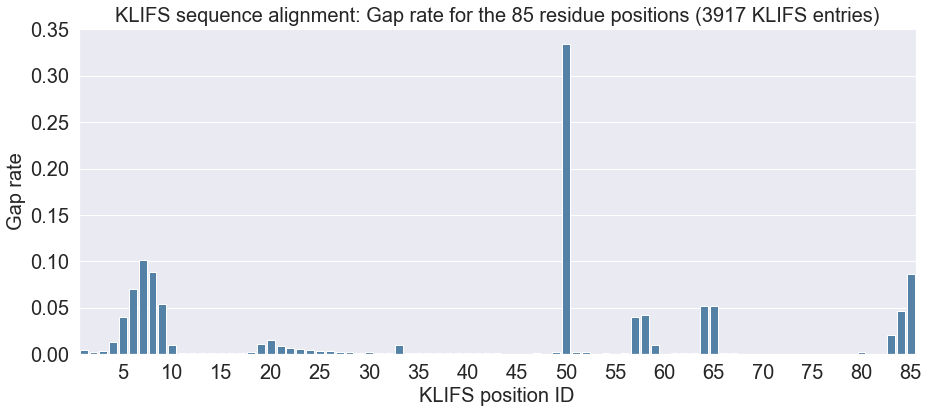

In [12]:
gap_rate.plot_gap_rate(path_to_results)

## Missing CA and CB atoms

In [13]:
with open(path_to_results / 'stats_missing_ca_cb_and_sco.p', 'rb') as f:
    sco_stats = pickle.load(f)

In [14]:
sco_stats.data

,klifs_id,residue_id,residue_name,ca,cb,com,sco,klifs_code
0,1,50,GLU,"<Vector -3.20, -23.46, -71.05>","<Vector -2.63, -22.05, -70.79>","<Vector -2.21, -22.21, -70.68>",94.16,HUMAN/AAK1_4wsq_altA_chainB
1,2,51,VAL,"<Vector -5.75, -22.67, -73.74>","<Vector -7.30, -22.87, -73.72>","<Vector -6.41, -22.39, -73.68>",21.29,HUMAN/AAK1_4wsq_altA_chainB
2,3,52,LEU,"<Vector -4.47, -19.59, -75.71>","<Vector -3.26, -19.64, -76.63>","<Vector -3.57, -19.55, -75.95>",27.98,HUMAN/AAK1_4wsq_altA_chainB
3,4,53,ALA,"<Vector -7.51, -18.97, -77.92>","<Vector -7.14, -17.87, -78.92>","<Vector -7.42, -19.51, -78.32>",22.51,HUMAN/AAK1_4wsq_altA_chainB
4,5,54,GLU,"<Vector -10.51, -20.69, -79.50>","<Vector -11.48, -21.24, -78.46>","<Vector -11.07, -20.30, -79.60>",25.87,HUMAN/AAK1_4wsq_altA_chainB
5,6,55,GLY,"<Vector -11.23, -19.12, -82.91>",None,"<Vector -10.73, -19.69, -83.41>",NaN,HUMAN/AAK1_4wsq_altA_chainB
6,7,56,GLY,"<Vector -12.19, -20.33, -86.39>",None,"<Vector -12.05, -21.11, -86.37>",NaN,HUMAN/AAK1_4wsq_altA_chainB
7,8,57,PHE,"<Vector -13.17, -23.98, -85.73>","<Vector -13.68, -24.45, -87.10>","<Vector -14.62, -23.75, -86.97>",89.28,HUMAN/AAK1_4wsq_altA_chainB
8,9,58,ALA,"<Vector -9.74, -24.57, -84.19>","<Vector -8.56, -24.24, -85.11>","<Vector -9.75, -23.97, -83.84>",23.05,HUMAN/AAK1_4wsq_altA_chainB
9,10,59,ILE,"<Vector -8.25, -24.25, -80.71>","<Vector -8.73, -25.11, -79.51>","<Vector -8.47, -24.92, -80.05>",16.58,HUMAN/AAK1_4wsq_altA_chainB


In [15]:
sco_stats.data.shape

(328229, 8)

In [16]:
sco_stats.get_missing_residues_ca_cb(gap_rate)

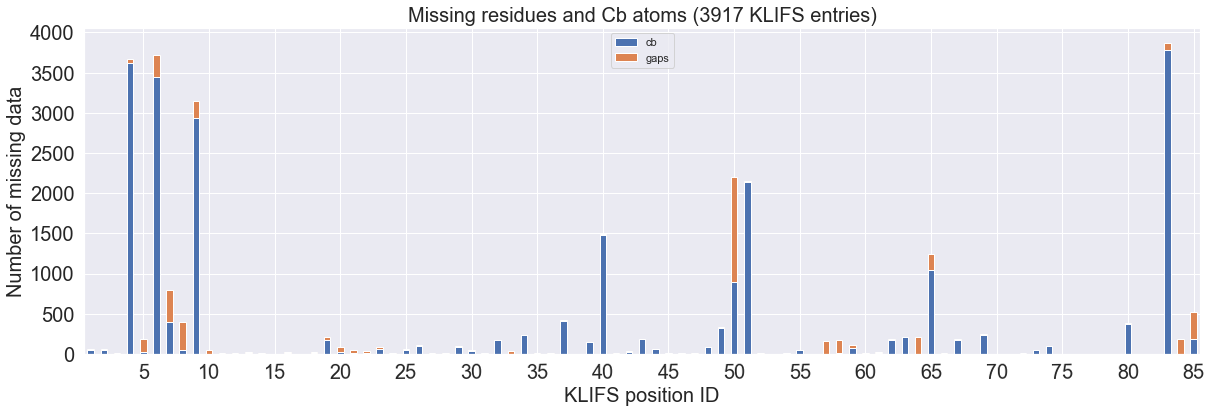

In [17]:
sco_stats.plot_missing_residues_ca_cb(path_to_results)

## SCO angle distribution

In [18]:
sco_stats.data

,klifs_id,residue_id,residue_name,ca,cb,com,sco,klifs_code
0,1,50,GLU,"<Vector -3.20, -23.46, -71.05>","<Vector -2.63, -22.05, -70.79>","<Vector -2.21, -22.21, -70.68>",94.16,HUMAN/AAK1_4wsq_altA_chainB
1,2,51,VAL,"<Vector -5.75, -22.67, -73.74>","<Vector -7.30, -22.87, -73.72>","<Vector -6.41, -22.39, -73.68>",21.29,HUMAN/AAK1_4wsq_altA_chainB
2,3,52,LEU,"<Vector -4.47, -19.59, -75.71>","<Vector -3.26, -19.64, -76.63>","<Vector -3.57, -19.55, -75.95>",27.98,HUMAN/AAK1_4wsq_altA_chainB
3,4,53,ALA,"<Vector -7.51, -18.97, -77.92>","<Vector -7.14, -17.87, -78.92>","<Vector -7.42, -19.51, -78.32>",22.51,HUMAN/AAK1_4wsq_altA_chainB
4,5,54,GLU,"<Vector -10.51, -20.69, -79.50>","<Vector -11.48, -21.24, -78.46>","<Vector -11.07, -20.30, -79.60>",25.87,HUMAN/AAK1_4wsq_altA_chainB
5,6,55,GLY,"<Vector -11.23, -19.12, -82.91>",None,"<Vector -10.73, -19.69, -83.41>",NaN,HUMAN/AAK1_4wsq_altA_chainB
6,7,56,GLY,"<Vector -12.19, -20.33, -86.39>",None,"<Vector -12.05, -21.11, -86.37>",NaN,HUMAN/AAK1_4wsq_altA_chainB
7,8,57,PHE,"<Vector -13.17, -23.98, -85.73>","<Vector -13.68, -24.45, -87.10>","<Vector -14.62, -23.75, -86.97>",89.28,HUMAN/AAK1_4wsq_altA_chainB
8,9,58,ALA,"<Vector -9.74, -24.57, -84.19>","<Vector -8.56, -24.24, -85.11>","<Vector -9.75, -23.97, -83.84>",23.05,HUMAN/AAK1_4wsq_altA_chainB
9,10,59,ILE,"<Vector -8.25, -24.25, -80.71>","<Vector -8.73, -25.11, -79.51>","<Vector -8.47, -24.92, -80.05>",16.58,HUMAN/AAK1_4wsq_altA_chainB


In [31]:
sco_stats.data[
    (sco_stats.data.cb.isna()) &
    (sco_stats.data.residue_name != 'GLY')
]

,klifs_id,residue_id,residue_name,ca,cb,com,sco,klifs_code
83,84,1273,MET,None,None,"<Vector 42.82, 41.39, 10.94>",NaN,HUMAN/ALK_2yjr_altB_chainA
4,5,1124,HIS,None,None,"<Vector 32.82, 46.56, -0.54>",NaN,HUMAN/ALK_2yjs_chainA
4,5,141,LYS,"<Vector -0.10, 13.06, 16.67>",None,"<Vector 0.37, 12.66, 15.96>",NaN,HUMAN/AurA_6c83_chainB
6,7,143,LYS,"<Vector 4.23, 7.96, 18.56>",None,"<Vector 4.19, 8.29, 19.30>",NaN,HUMAN/AurA_6c83_chainB
7,8,144,PHE,"<Vector 5.92, 9.49, 21.62>",None,"<Vector 5.34, 9.93, 21.90>",NaN,HUMAN/AurA_6c83_chainB
66,67,253,ILE,"<Vector 26.61, 22.32, 21.10>",None,"<Vector 25.96, 22.44, 20.52>",NaN,HUMAN/AurA_6c83_chainB
6,7,412,GLN,"<Vector 6.20, 1.14, -34.56>",None,"<Vector 5.98, 0.89, -34.06>",NaN,HUMAN/BTK_4yhf_altA_chainB
84,85,543,SER,"<Vector -17.92, 13.54, -2.44>",None,"<Vector -18.37, 13.30, -2.97>",NaN,HUMAN/BTK_5fbo_altB_chainA
83,85,149,ALA,None,None,"<Vector -12.25, 32.53, 22.23>",NaN,HUMAN/CDK2_2r3n_altB_chainA
81,84,148,LEU,"<Vector 16.10, 4.44, 53.40>",None,"<Vector 15.93, 5.22, 52.84>",NaN,HUMAN/CDK2_5fp5_chainA


In [32]:
sco_stats.data[
    (sco_stats.data.klifs_code == 'HUMAN/AurA_6c83_chainB')
]

,klifs_id,residue_id,residue_name,ca,cb,com,sco,klifs_code
0,1,137,ARG,"<Vector -7.59, 21.20, 17.33>","<Vector -7.83, 21.63, 15.88>","<Vector -6.91, 21.41, 17.31>",24.34,HUMAN/AurA_6c83_chainB
1,2,138,PRO,"<Vector -4.75, 18.62, 17.40>","<Vector -5.08, 17.12, 17.44>","<Vector -5.41, 18.29, 16.94>",34.38,HUMAN/AurA_6c83_chainB
2,3,139,LEU,"<Vector -1.87, 19.95, 15.32>","<Vector -0.94, 21.09, 15.75>","<Vector -1.45, 20.87, 15.48>",28.00,HUMAN/AurA_6c83_chainB
3,4,140,GLY,"<Vector -0.11, 16.57, 15.27>",None,"<Vector -0.53, 16.36, 16.14>",NaN,HUMAN/AurA_6c83_chainB
4,5,141,LYS,"<Vector -0.10, 13.06, 16.67>",None,"<Vector 0.37, 12.66, 15.96>",NaN,HUMAN/AurA_6c83_chainB
5,6,142,GLY,"<Vector 3.05, 10.92, 16.51>",None,"<Vector 2.48, 10.43, 17.11>",NaN,HUMAN/AurA_6c83_chainB
6,7,143,LYS,"<Vector 4.23, 7.96, 18.56>",None,"<Vector 4.19, 8.29, 19.30>",NaN,HUMAN/AurA_6c83_chainB
7,8,144,PHE,"<Vector 5.92, 9.49, 21.62>",None,"<Vector 5.34, 9.93, 21.90>",NaN,HUMAN/AurA_6c83_chainB
8,9,145,GLY,"<Vector 3.16, 12.10, 21.98>",None,"<Vector 2.94, 12.09, 21.04>",NaN,HUMAN/AurA_6c83_chainB
9,10,146,ASN,"<Vector 1.03, 14.81, 20.37>","<Vector -0.39, 14.24, 20.32>","<Vector 0.27, 14.62, 21.36>",52.15,HUMAN/AurA_6c83_chainB


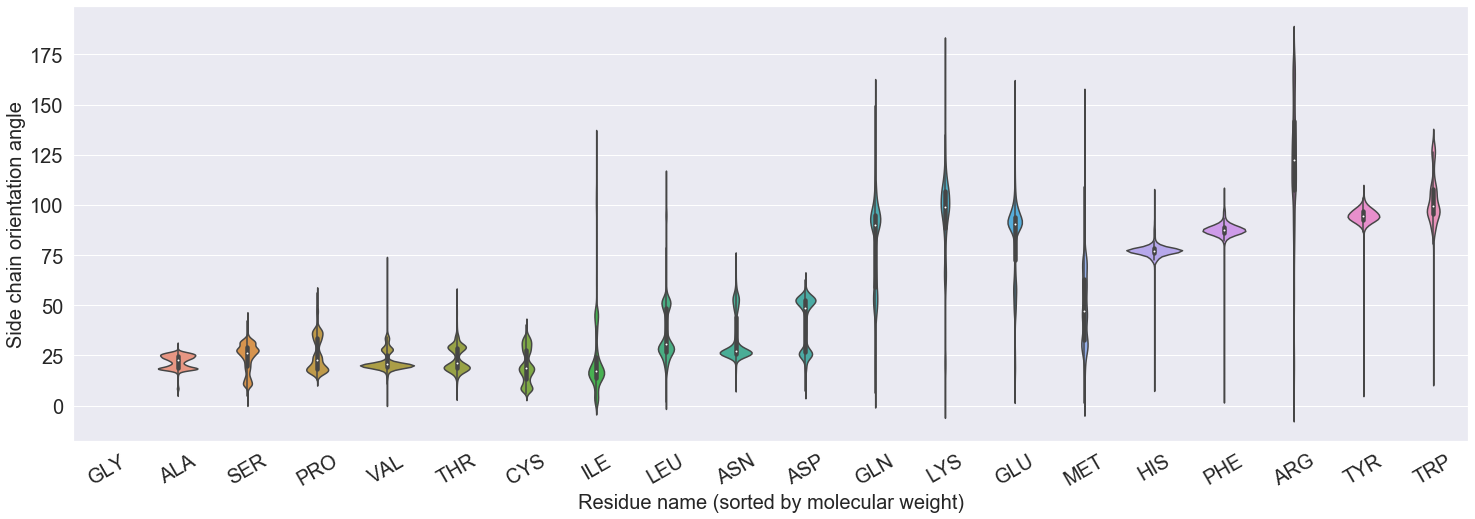

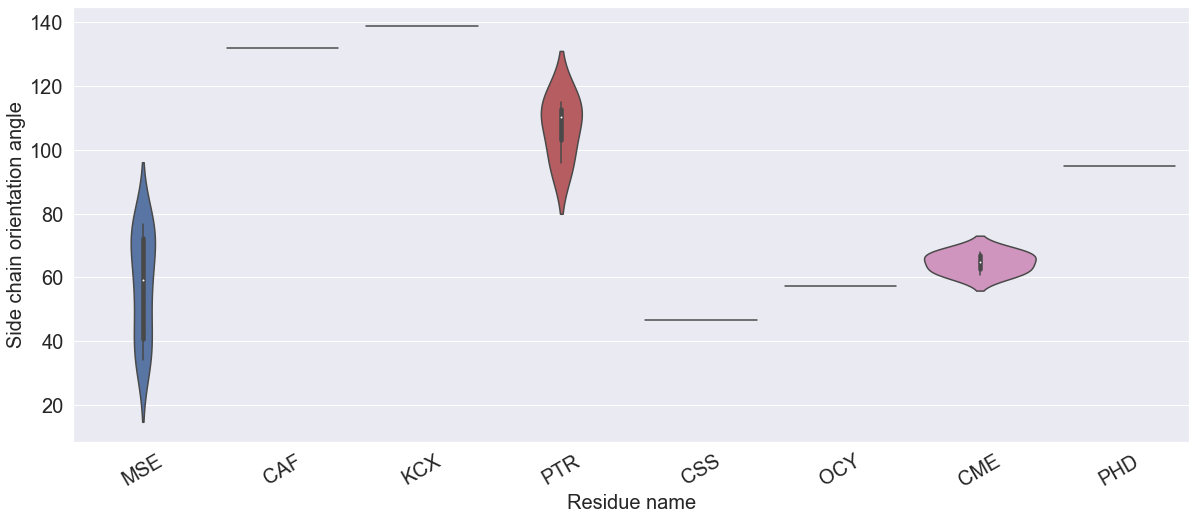

In [19]:
sco_stats.plot_side_chain_orientation_distribution(path_to_results, kind='violin')

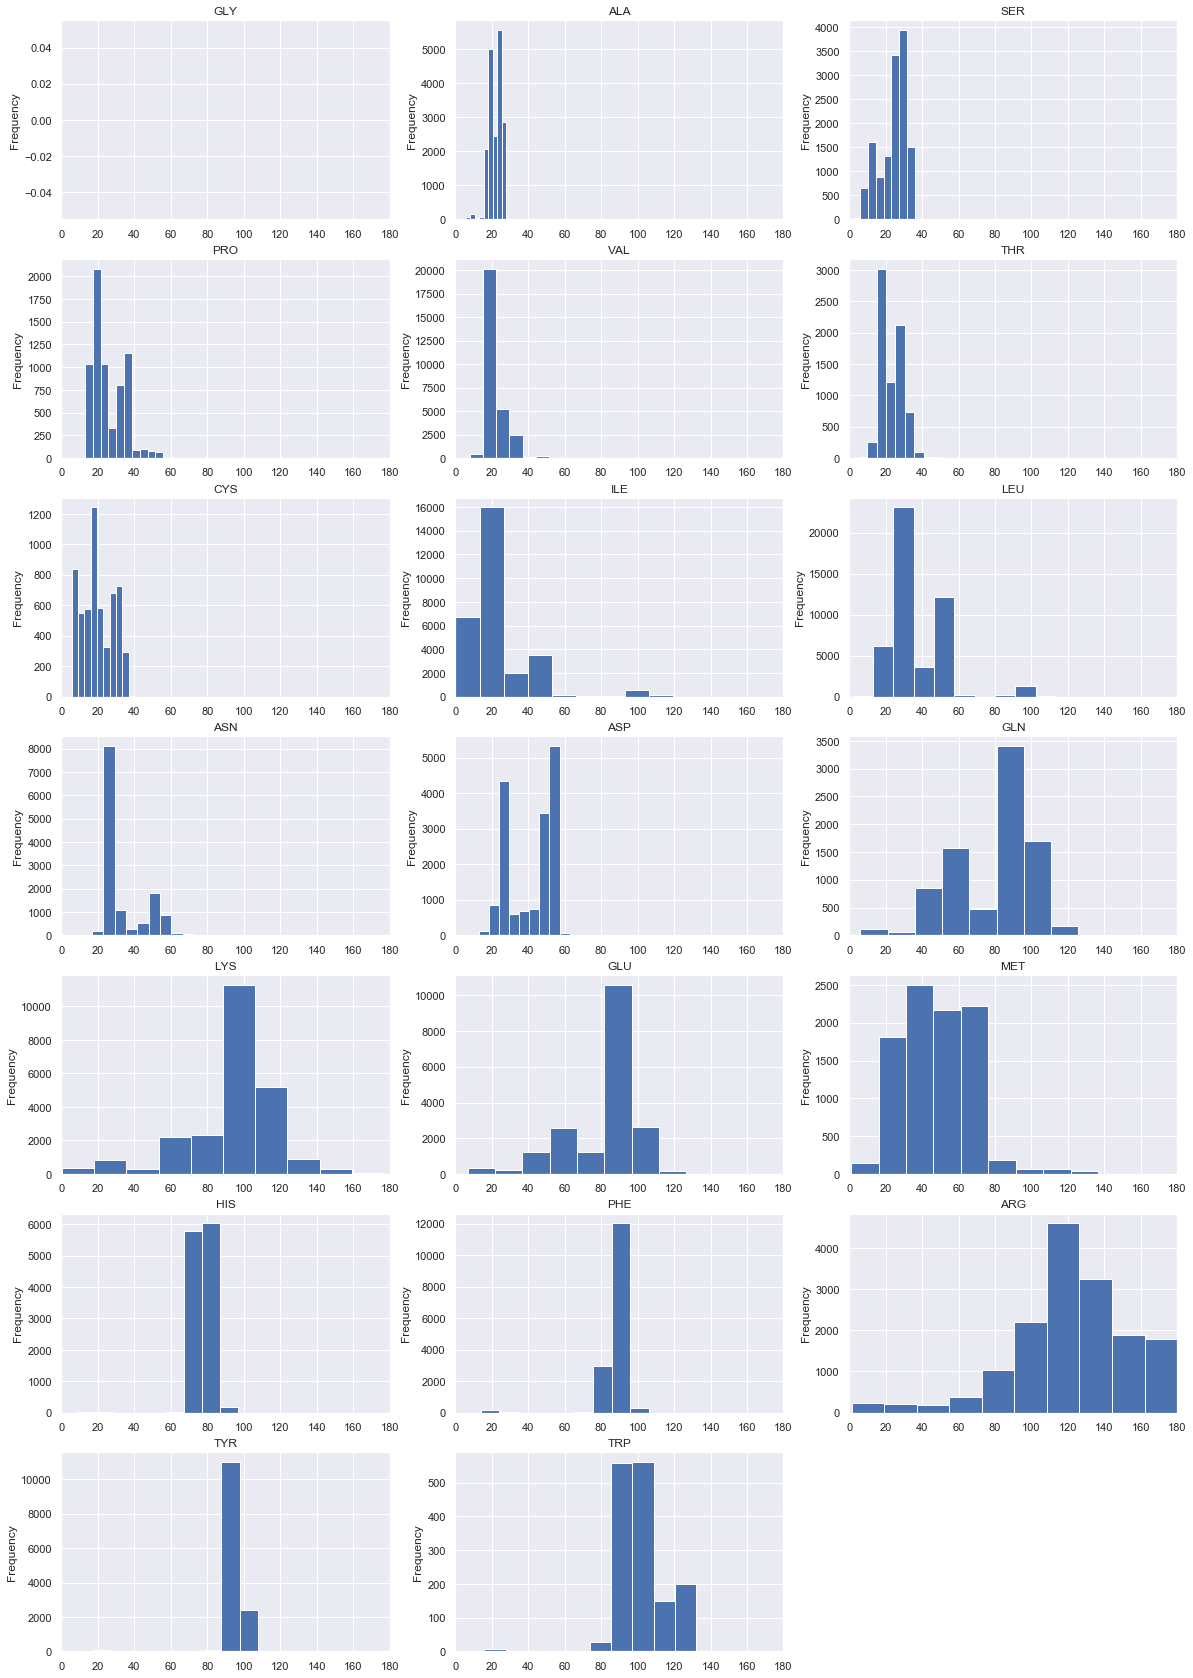

In [20]:
sco_stats.plot_side_chain_orientation_distribution(path_to_results, kind='histograms')

Get mean and median of side chain orientation angles per amino acid and save to file. 
Use these values for residues with missing Ca/Cb atoms.

In [22]:
sco_stats.get_mean_median(from_file='../results/stats_missing_ca_cb_and_sco.p')

,sco_mean,sco_median
residue_name,,
ALA,21.84,22.51
ARG,121.40,122.16
ASN,33.60,27.19
ASP,41.46,48.61
CAF,132.03,132.03
CME,64.61,64.79
CSS,46.53,46.53
CYS,19.91,18.79
GLN,80.12,89.86
